__Частина 1__

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів `Keras`, яка буде класифікувати товари із датасету `fasion_mnist`.

На відміну від попереднього завдання вам пропонується створити `згорткову нейромережу`. Підберіть архітектуру мережі та навчіть її на даних із датасету fasion_mnist. Спробуйте досягти `максимально можливої точності класифікації` за рахунок `маніпуляції параметрами` мережі. `Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання`. Зробіть висновки.
<br><br>
__Частина 2__

В цій частині ми знову будемо працювати з датасетом `fasion_mnist`.

На відміну від попереднього завдання вам пропонується створити `згорткову нейромережу`, що використовує `VGG16` в якості згорткової основи.

Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти `максимально можливої точності класифікації` за рахунок `маніпуляції параметрами` мережі. Під час навчання використовуйте `прийоми донавчання` та `виділення ознак`.

`Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання`. Зробіть висновки.

In [165]:
import itertools
import math 

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import mish, relu, sigmoid, softmax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import losses
from keras import metrics
from keras import models
from keras import optimizers
from sklearn.model_selection import train_test_split


# __Part 1__

##### __Dataset__

- https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data

In [3]:
(images_train, labels_train), (images_test, labels_test) = fashion_mnist.load_data()
images_train.dtype, images_train[0].shape

(dtype('uint8'), (28, 28))

In [4]:
# each sample (28x28) = 784
NUM_FEATURES = images_train[0].shape[0] * images_train[0].shape[1]
NUM_FEATURES

784

In [5]:
images_train, images_test = np.array(images_train, np.float32), np.array(images_test, np.float32)  # .astype('float32')

# images_train, images_test = images_train.reshape([-1, NUM_FEATURES]), images_test.reshape([-1, NUM_FEATURES])
print(min(images_train.min(), images_test.min()))
maximum = max(images_train.max(), images_test.max()) # np.max([images_train.max(), images_test.max()]) 
maximum

0.0


255.0

In [6]:
# Normalize (min = 0):
images_train, images_test = images_train / maximum, images_test / maximum

In [7]:
images_train.shape, images_test.shape, labels_train.shape, labels_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [8]:
max(labels_train.max(), labels_test.max()), min(labels_train.min(), labels_test.min())

(9, 0)

In [9]:
NUM_CLASSES = len(set(np.concatenate((labels_train, labels_test), axis=0)))
NUM_CLASSES

10

In [10]:
images_valid, images_test, labels_valid, labels_test = train_test_split(
                                                                        images_test, 
                                                                        labels_test, 
                                                                        test_size=0.5,  # 50%
                                                                        shuffle=True, 
                                                                        stratify=labels_test
                                                                        )  # (stratify для рівномірного розподілу за значенням y)

In [11]:
labels_train = tf.one_hot(labels_train, depth=NUM_CLASSES).numpy()
labels_test = tf.one_hot(labels_test, depth=NUM_CLASSES).numpy()
labels_valid = tf.one_hot(labels_valid, depth=NUM_CLASSES).numpy()
# labels_train = to_categorical(labels_train, num_classes = NUM_CLASSES)
# labels_valid = to_categorical(labels_valid, num_classes = NUM_CLASSES)
labels_train.shape, labels_test.shape, labels_valid.shape  # ((60000, 10), (10000, 10)) to ((60000, 10), (5000, 10), (5000, 10))

((60000, 10), (5000, 10), (5000, 10))

In [12]:
images_train.shape, images_test.shape, images_valid.shape, labels_train.shape, labels_test.shape, labels_valid.shape

((60000, 28, 28),
 (5000, 28, 28),
 (5000, 28, 28),
 (60000, 10),
 (5000, 10),
 (5000, 10))

##### __Model__

- https://keras.io/api/layers/convolution_layers/convolution2d/
- https://keras.io/api/layers/pooling_layers/max_pooling2d/
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten

In [114]:
kernel_window_size_1 = 3  # 5, 9, 11
kernel_window_size_2 = 3  # 5, 9, 11
kernel_window_size_3 = 3  # 5, 9, 11
filters_1 = 32  # output_depth
filters_2 = 64
filters_3 = 64
filters_4 = 64
# activation_functions = ['relu' for _ in range(4)] + ['softmax']

In [115]:
model = models.Sequential([
                           layers.Conv2D(
                                         filters_1, 
                                         (kernel_window_size_1, kernel_window_size_1), 
                                         activation='relu', 
                                         input_shape=(images_train.shape[1], images_train.shape[2], 1)  # channels 1 - gray, 3 - RGB
                                         ),  
                           layers.MaxPooling2D((2, 2)),

                           layers.Conv2D(
                                         filters_2, 
                                         (kernel_window_size_2, kernel_window_size_2), 
                                         activation='relu'
                                         ),
                           layers.MaxPooling2D((2, 2)),

                           layers.Conv2D(
                                         filters_3, 
                                         (kernel_window_size_3, kernel_window_size_3), 
                                         activation='relu'
                                         ),

                           layers.Flatten(),
                           layers.Dense(
                                        filters_4, 
                                        activation='relu'
                                        ),

                           layers.Dense(
                                        NUM_CLASSES, 
                                        activation='softmax'
                                        )
                           ])

In [116]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_4 (Flatten)         (None, 576)              

In [117]:
model.compile(
              optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

##### __Training__

In [118]:
history = model.fit(images_train, labels_train, epochs=5, batch_size=64)  # w/o valid data

Epoch 1/5
938/938 [==============================] - 9s 9ms/step - loss: 0.5649 - accuracy: 0.7914
Epoch 2/5
938/938 [==============================] - 9s 10ms/step - loss: 0.3370 - accuracy: 0.8785
Epoch 3/5
938/938 [==============================] - 9s 10ms/step - loss: 0.2838 - accuracy: 0.8967
Epoch 4/5
938/938 [==============================] - 10s 10ms/step - loss: 0.2527 - accuracy: 0.9071
Epoch 5/5
938/938 [==============================] - 10s 10ms/step - loss: 0.2282 - accuracy: 0.9164


##### __Error Analysis__

In [119]:
history.history

{'loss': [0.5649124383926392,
  0.33701926469802856,
  0.28380846977233887,
  0.2527290880680084,
  0.22820459306240082],
 'accuracy': [0.7913500070571899,
  0.8785333037376404,
  0.8966666460037231,
  0.9071000218391418,
  0.9164333343505859]}

In [120]:
valid_loss, valid_acc = model.evaluate(images_valid, labels_valid)
print(valid_acc)
test_loss, test_acc = model.evaluate(images_test, labels_test)
print(test_acc)

157/157 [==============================] - 1s 3ms/step - loss: 0.2791 - accuracy: 0.9038
0.9038000106811523
157/157 [==============================] - 0s 3ms/step - loss: 0.2779 - accuracy: 0.9006
0.900600016117096


In [142]:
def draw_2twin_2d(y00: np.array, y01: np.array, y10: np.array, y11: np.array, suptitle: str) -> None:
    x = range(1, len(y00) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))

    axs[0].plot(x, y00, 'bo', label='Training loss')
    axs[0].plot(x, y01, 'g', label='Validation loss')
    axs[0].title.set_text('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(x, y10, 'bo', label='Training acc')
    axs[1].plot(x, y11, 'g', label='Validation acc')
    axs[1].title.set_text('Training and validation acc')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Acc')
    axs[1].legend()
    axs[1].grid()
    
    fig.suptitle(suptitle)
    # plt.legend()
    # plt.grid()
    axs[1].grid()
    plt.show()

##### __repeating+__

In [141]:
def create_NN(filters: list, kernel_window_size: list, activation: list, optimizer=optimizers.SGD, learning_rate=0.1) -> Sequential:
    model = Sequential(
                       name=f'''m-{''.join([f'f{f}-kws{kws}-a{a}-' for f, kws, a in zip(filters, kernel_window_size, activation)])}{optimizer.__name__}-{learning_rate}'''
                    #    name=f'''m-{''.join(map(str, [f'{i}-' for i in n_hidden_[1:-1]]))}{''.join(map(str, [f'{a}-' for a in activation[:-1]]))}{optimizer.__name__}-{learning_rate}'''
                       )
    ni1, ni2, ni3 = images_train.shape[1], images_train.shape[2], 1  # channels 1 - gray, 3 - RGB
    for num, (f, kws, a) in enumerate(zip(filters, kernel_window_size, activation)):
        model.add(
                  layers.Conv2D(
                                f, 
                                (kws, kws), 
                                activation=a, 
                                input_shape=(ni1, ni2, ni3)  
                                )
                  )
        model.add(layers.MaxPooling2D((2, 2))) if num != len(kernel_window_size) -1  else None
        ni1, ni2, ni3 = (ni1 - 2) // 2, (ni2 - 2) // 2, f
    
    model.add(layers.Flatten())
    model.add(layers.Dense(filters[-1], activation=activation[-1]))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
    
    model.compile(
                  optimizer=optimizer(learning_rate=learning_rate), # legacy
                  loss=losses.CategoricalCrossentropy(), 
                  metrics=['accuracy', metrics.CategoricalAccuracy()]  # metrics.BinaryAccuracy()
                  )

    return model

In [142]:
def retest_NN(filters: list, windows: list, act: list, opt: optimizers, lr: float, bs: int, epochs: int=100) -> Sequential:
    """For retest one model."""
    models = [create_NN(
                        filters=filters, 
                        kernel_window_size=windows,
                        activation=act, 
                        optimizer=opt, 
                        learning_rate=lr
                        )] 

    history = {}
    history[f'{models[0].name}({bs})'] = models[0].fit(
                                                       images_train, 
                                                       labels_train,
                                                       epochs=epochs,
                                                       batch_size=bs,
                                                       validation_data=(images_valid, labels_valid)
                                                       )

    for model in history:
        history_dict = history[model].history

        loss_values = history_dict['loss']
        val_loss_values = history_dict['val_loss']
        acc_values = history_dict['categorical_accuracy']
        val_acc_values = history_dict['val_categorical_accuracy']   

        draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=model)

    return models[0]

###### __retest__

Epoch 1/100
118/118 [==============================] - 7s 60ms/step - loss: 0.9002 - accuracy: 0.6700 - categorical_accuracy: 0.6700 - val_loss: 0.7409 - val_accuracy: 0.7328 - val_categorical_accuracy: 0.7328
Epoch 2/100
118/118 [==============================] - 7s 59ms/step - loss: 0.5233 - accuracy: 0.8044 - categorical_accuracy: 0.8044 - val_loss: 0.5175 - val_accuracy: 0.8118 - val_categorical_accuracy: 0.8118
Epoch 3/100
118/118 [==============================] - 7s 57ms/step - loss: 0.4324 - accuracy: 0.8406 - categorical_accuracy: 0.8406 - val_loss: 0.4503 - val_accuracy: 0.8336 - val_categorical_accuracy: 0.8336
Epoch 4/100
118/118 [==============================] - 7s 61ms/step - loss: 0.3810 - accuracy: 0.8598 - categorical_accuracy: 0.8598 - val_loss: 0.4015 - val_accuracy: 0.8552 - val_categorical_accuracy: 0.8552
Epoch 5/100
118/118 [==============================] - 7s 57ms/step - loss: 0.3462 - accuracy: 0.8730 - categorical_accuracy: 0.8730 - val_loss: 0.3701 - val_ac

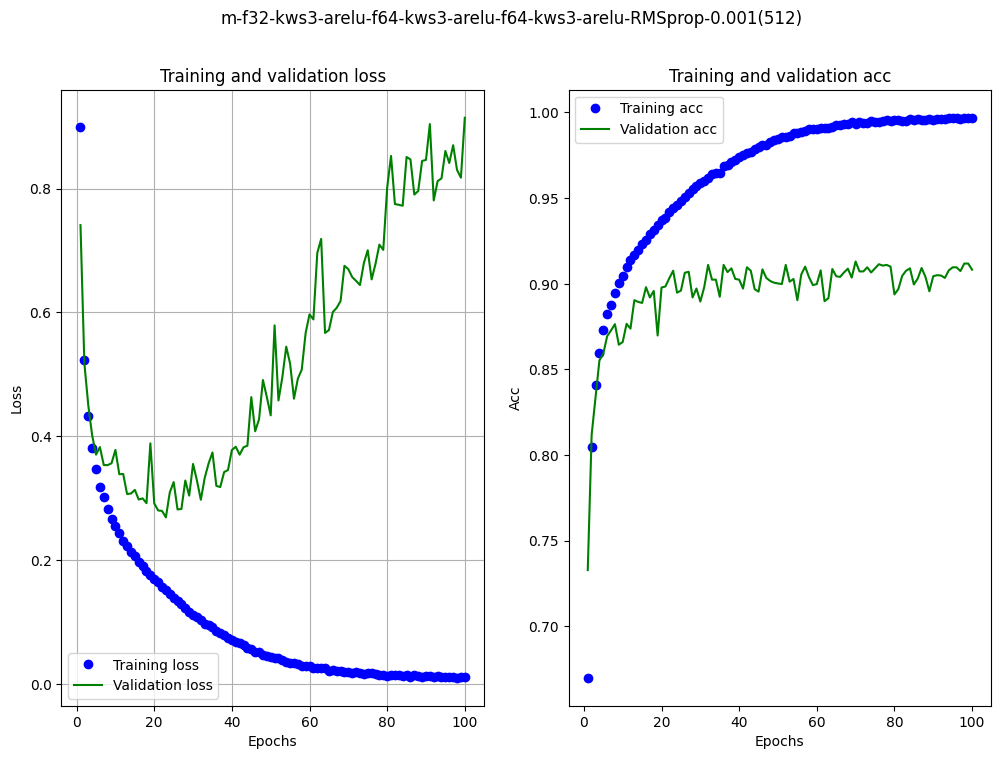

In [145]:
model_0 = retest_NN(
                    filters=[32, 64, 64, 64], 
                    windows=[3, 3, 3],
                    act=['relu' for _ in range(4)],  # mish sigmoid
                    opt=optimizers.legacy.RMSprop,  # Adadelta Adam
                    lr=0.001,
                    bs=512,
                    epochs=100
                    )

За автоматичним встановленням `'accuracy'` обирається `metrics.CategoricalAccuracy()`, значення `accuracy` та `categorical_accuracy` - __ідентичні__.

Для моделі-0 з 23-ї епохи помітний початок `перенавчання`, тренувальні loss: 0.1510 - accuracy: 0.9440, валідаційні - val_loss: 0.2689 - `val_accuracy`: __0.9076__.<br>
8 c тренування на епоху.

In [146]:
model_0.summary()

Model: "m-f32-kws3-arelu-f64-kws3-arelu-f64-kws3-arelu-RMSprop-0.001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatt

Замінимо `relu` на `sigmoid`:

Epoch 1/100
118/118 [==============================] - 8s 64ms/step - loss: 2.1456 - accuracy: 0.2218 - categorical_accuracy: 0.2218 - val_loss: 1.5915 - val_accuracy: 0.5110 - val_categorical_accuracy: 0.5110
Epoch 2/100
118/118 [==============================] - 7s 62ms/step - loss: 1.1967 - accuracy: 0.6173 - categorical_accuracy: 0.6173 - val_loss: 1.0225 - val_accuracy: 0.6478 - val_categorical_accuracy: 0.6478
Epoch 3/100
118/118 [==============================] - 7s 63ms/step - loss: 0.8881 - accuracy: 0.6905 - categorical_accuracy: 0.6905 - val_loss: 0.8352 - val_accuracy: 0.6934 - val_categorical_accuracy: 0.6934
Epoch 4/100
118/118 [==============================] - 7s 62ms/step - loss: 0.7743 - accuracy: 0.7168 - categorical_accuracy: 0.7168 - val_loss: 0.8137 - val_accuracy: 0.6908 - val_categorical_accuracy: 0.6908
Epoch 5/100
118/118 [==============================] - 7s 63ms/step - loss: 0.7084 - accuracy: 0.7356 - categorical_accuracy: 0.7356 - val_loss: 0.7351 - val_ac

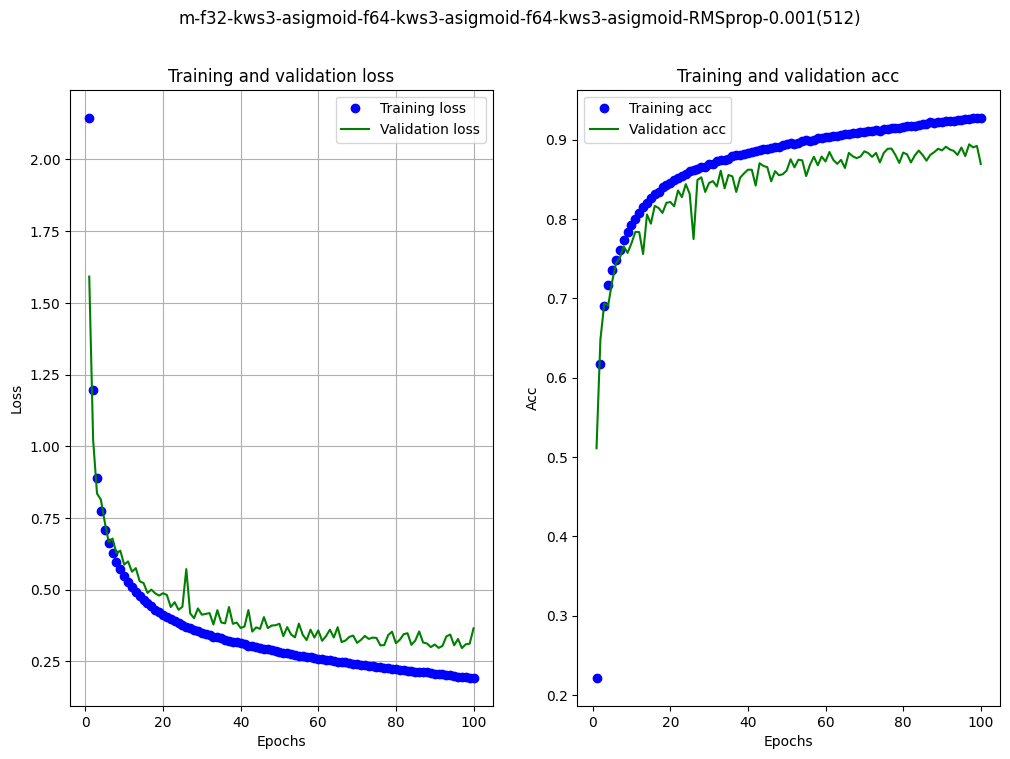

In [147]:
model_1 = retest_NN(
                    filters=[32, 64, 64, 64], 
                    windows=[3, 3, 3],
                    act=['sigmoid' for _ in range(4)],  # mish sigmoid
                    opt=optimizers.legacy.RMSprop,  # Adadelta Adam
                    lr=0.001,
                    bs=512,
                    epochs=100
                    )

Для моделі-1 за 100 епох найкращим результатом можна вважати 98 епоху: тренувальні - loss: 0.1966 - accuracy: 0.9258, валідаційні - val_loss: 0.2962 - `val_accuracy`: __0.8940__<br>
8.6 c тренування на епоху.

Трішки гірший результат за модель-0, але все одно - кращий за багатошарові мережі з попереднього завдання.

Змінимо опримізатор на відміну від моделі-0:

Epoch 1/100
118/118 [==============================] - 7s 57ms/step - loss: 0.8930 - accuracy: 0.6732 - categorical_accuracy: 0.6732 - val_loss: 0.6121 - val_accuracy: 0.7764 - val_categorical_accuracy: 0.7764
Epoch 2/100
118/118 [==============================] - 7s 55ms/step - loss: 0.5192 - accuracy: 0.8071 - categorical_accuracy: 0.8071 - val_loss: 0.4887 - val_accuracy: 0.8240 - val_categorical_accuracy: 0.8240
Epoch 3/100
118/118 [==============================] - 7s 56ms/step - loss: 0.4466 - accuracy: 0.8366 - categorical_accuracy: 0.8366 - val_loss: 0.4629 - val_accuracy: 0.8300 - val_categorical_accuracy: 0.8300
Epoch 4/100
118/118 [==============================] - 7s 55ms/step - loss: 0.4062 - accuracy: 0.8539 - categorical_accuracy: 0.8539 - val_loss: 0.4068 - val_accuracy: 0.8572 - val_categorical_accuracy: 0.8572
Epoch 5/100
118/118 [==============================] - 7s 56ms/step - loss: 0.3732 - accuracy: 0.8668 - categorical_accuracy: 0.8668 - val_loss: 0.3771 - val_ac

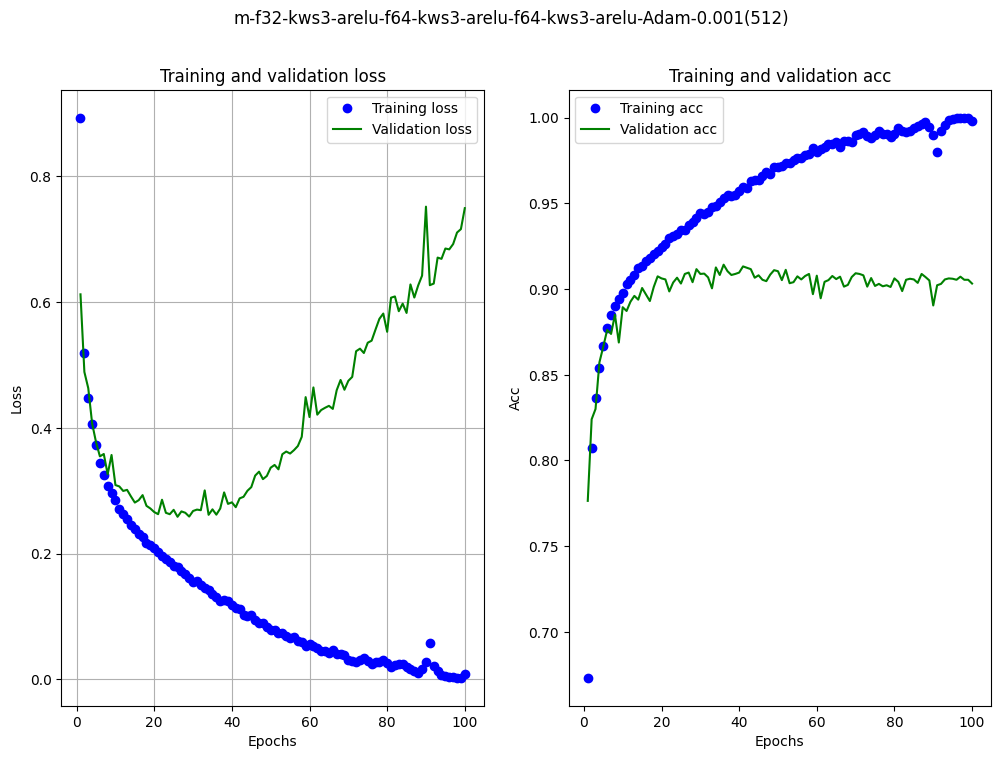

In [148]:
model_2 = retest_NN(
                    filters=[32, 64, 64, 64], 
                    windows=[3, 3, 3],
                    act=['relu' for _ in range(4)],  # mish sigmoid
                    opt=optimizers.legacy.Adam,  # Adadelta Adam
                    lr=0.001,
                    bs=512,
                    epochs=100
                    )

Після 26ї епохи явний початок перенавчання, оптимальне значення: тренувальної - loss: 0.1783 - accuracy: 0.9342, валідаційної - val_loss: 0.2584 - `val_accuracy`: __0.9088__
<br>
Незначно краще за модель-0. <br>8 c тренування на епоху.

Epoch 1/100
118/118 [==============================] - 7s 57ms/step - loss: 1.1512 - accuracy: 0.6468 - categorical_accuracy: 0.6468 - val_loss: 0.6070 - val_accuracy: 0.7676 - val_categorical_accuracy: 0.7676
Epoch 2/100
118/118 [==============================] - 7s 56ms/step - loss: 0.4481 - accuracy: 0.8320 - categorical_accuracy: 0.8320 - val_loss: 0.4454 - val_accuracy: 0.8338 - val_categorical_accuracy: 0.8338
Epoch 3/100
118/118 [==============================] - 7s 56ms/step - loss: 0.3632 - accuracy: 0.8655 - categorical_accuracy: 0.8655 - val_loss: 0.4822 - val_accuracy: 0.8280 - val_categorical_accuracy: 0.8280
Epoch 4/100
118/118 [==============================] - 7s 56ms/step - loss: 0.3211 - accuracy: 0.8794 - categorical_accuracy: 0.8794 - val_loss: 0.4254 - val_accuracy: 0.8466 - val_categorical_accuracy: 0.8466
Epoch 5/100
118/118 [==============================] - 7s 56ms/step - loss: 0.2950 - accuracy: 0.8875 - categorical_accuracy: 0.8875 - val_loss: 0.4576 - val_ac

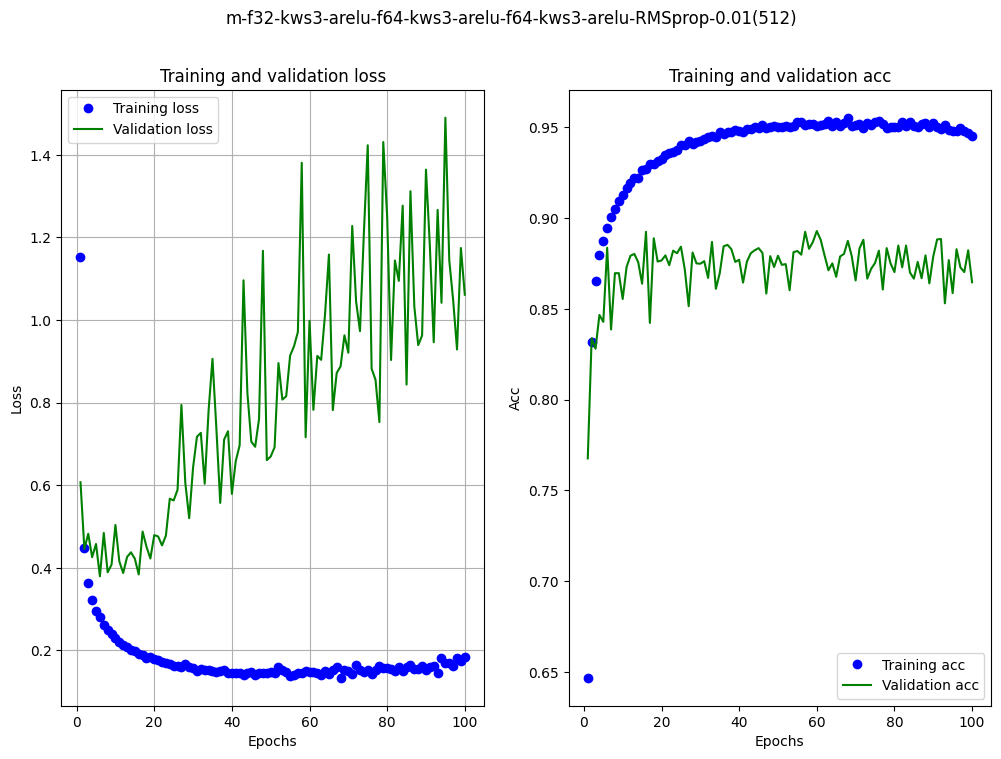

In [149]:
model_3 = retest_NN(
                    filters=[32, 64, 64, 64], 
                    windows=[3, 3, 3],
                    act=['relu' for _ in range(4)],  # mish sigmoid
                    opt=optimizers.legacy.RMSprop,  # Adadelta Adam
                    lr=0.01,
                    bs=512,
                    epochs=100
                    )

 Збільшуючи рейтинг-швидкості навчання (`lr`) - просто змістили(зменшили) оптимум кількості епох, точність трішки впала, втрати - зросли.

Збільшення розміру батчів майже не вплинуло:

Epoch 1/100
59/59 [==============================] - 7s 109ms/step - loss: 1.0654 - accuracy: 0.6145 - categorical_accuracy: 0.6145 - val_loss: 0.7913 - val_accuracy: 0.7086 - val_categorical_accuracy: 0.7086
Epoch 2/100
59/59 [==============================] - 6s 106ms/step - loss: 0.6486 - accuracy: 0.7542 - categorical_accuracy: 0.7542 - val_loss: 0.6476 - val_accuracy: 0.7576 - val_categorical_accuracy: 0.7576
Epoch 3/100
59/59 [==============================] - 6s 106ms/step - loss: 0.5551 - accuracy: 0.7885 - categorical_accuracy: 0.7885 - val_loss: 0.5306 - val_accuracy: 0.8024 - val_categorical_accuracy: 0.8024
Epoch 4/100
59/59 [==============================] - 6s 106ms/step - loss: 0.4920 - accuracy: 0.8153 - categorical_accuracy: 0.8153 - val_loss: 0.4700 - val_accuracy: 0.8272 - val_categorical_accuracy: 0.8272
Epoch 5/100
59/59 [==============================] - 6s 106ms/step - loss: 0.4416 - accuracy: 0.8375 - categorical_accuracy: 0.8375 - val_loss: 0.4294 - val_accurac

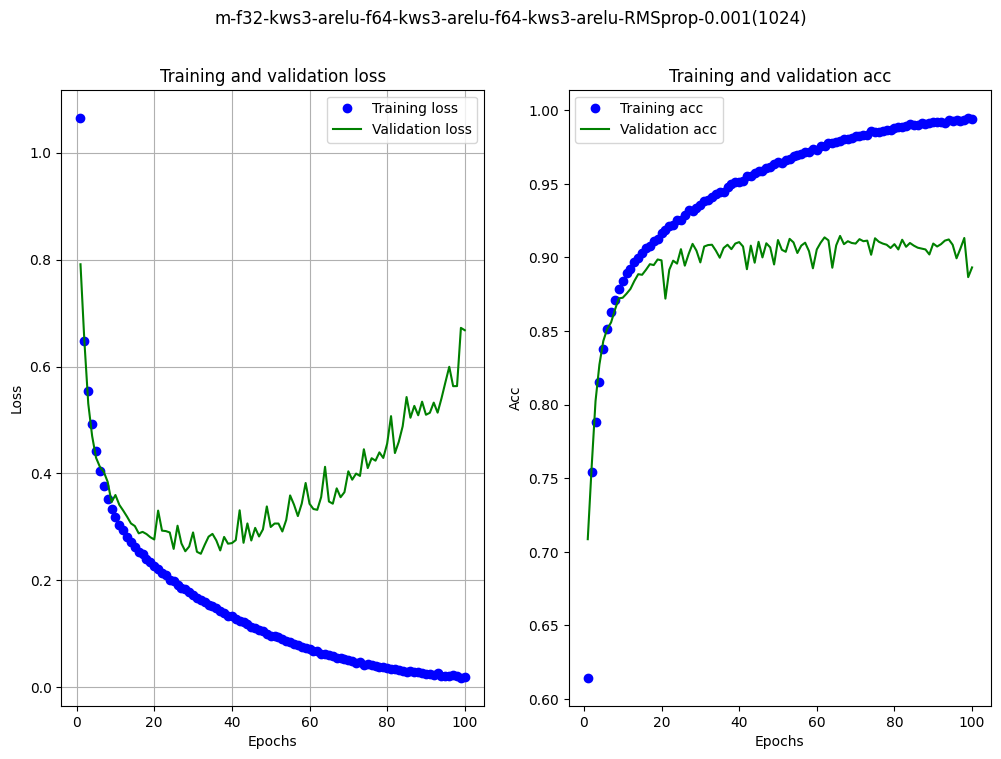

In [150]:
model_4 = retest_NN(
                    filters=[32, 64, 64, 64], 
                    windows=[3, 3, 3],
                    act=['relu' for _ in range(4)],  # mish sigmoid
                    opt=optimizers.legacy.RMSprop,  # Adadelta Adam
                    lr=0.001,
                    bs=1024,
                    epochs=100
                    )

З 32-ї епохи помітний початок `перенавчання`, тренувальні - loss: 0.1637 - accuracy: 0.9389, валідаційні  - val_loss: 0.2497 - `val_accuracy`: __0.9084__.<br>
6.1 c тренування на епоху. Всюди трішечки краще за модель-0.

За розширення вікна згортки з 3 до 5, враховуючи малий розмір вихідних зображень - зменшуємо кількість шарів.

Epoch 1/100
118/118 [==============================] - 8s 64ms/step - loss: 0.7974 - accuracy: 0.7122 - categorical_accuracy: 0.7122 - val_loss: 0.6084 - val_accuracy: 0.7762 - val_categorical_accuracy: 0.7762
Epoch 2/100
118/118 [==============================] - 7s 63ms/step - loss: 0.4433 - accuracy: 0.8389 - categorical_accuracy: 0.8389 - val_loss: 0.4659 - val_accuracy: 0.8282 - val_categorical_accuracy: 0.8282
Epoch 3/100
118/118 [==============================] - 7s 62ms/step - loss: 0.3633 - accuracy: 0.8682 - categorical_accuracy: 0.8682 - val_loss: 0.4443 - val_accuracy: 0.8410 - val_categorical_accuracy: 0.8410
Epoch 4/100
118/118 [==============================] - 7s 63ms/step - loss: 0.3179 - accuracy: 0.8851 - categorical_accuracy: 0.8851 - val_loss: 0.3548 - val_accuracy: 0.8706 - val_categorical_accuracy: 0.8706
Epoch 5/100
118/118 [==============================] - 7s 63ms/step - loss: 0.2848 - accuracy: 0.8958 - categorical_accuracy: 0.8958 - val_loss: 0.3288 - val_ac

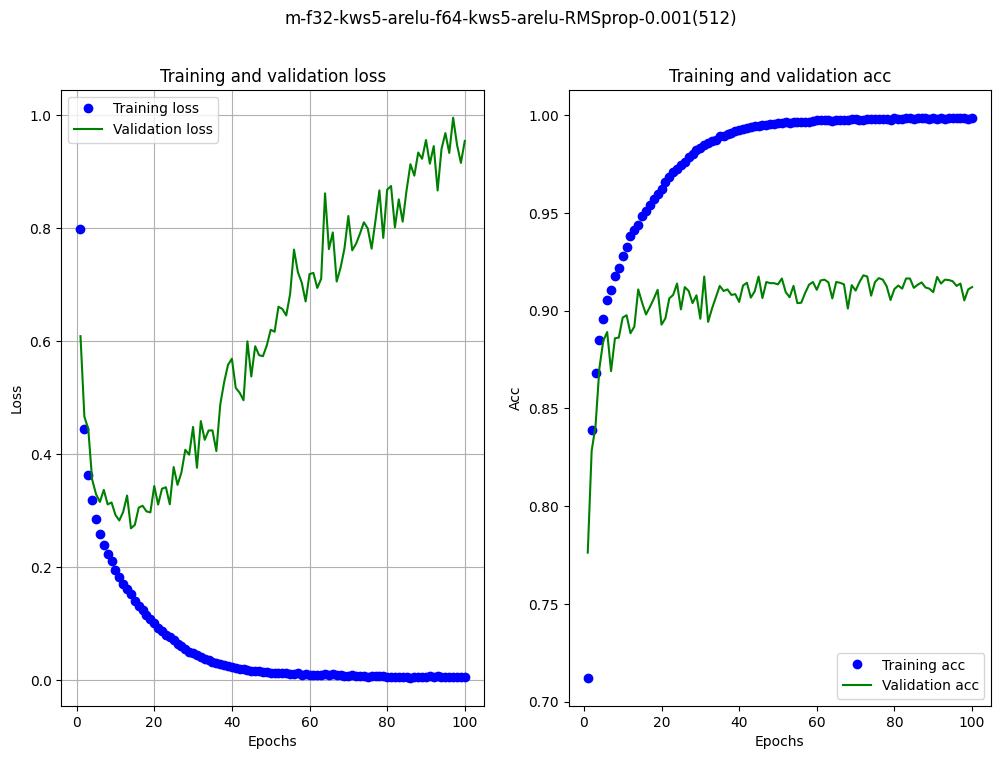

In [155]:
model_5 = retest_NN(
                    filters=[32, 64, 64], 
                    windows=[5, 5],
                    act=['relu' for _ in range(4)],  # mish sigmoid
                    opt=optimizers.legacy.RMSprop,  # Adadelta Adam
                    lr=0.001,
                    bs=512,
                    epochs=100
                    )

З 17-ї епохи помітний початок `перенавчання`, тренувальні - loss: 0.1516 - accuracy: 0.9438, валідаційні - val_loss: 0.2684 - `val_accuracy`: __0.9108__.<br>
7.6 c тренування на епоху.

Зменшимо кількість фільтрів, на відміну від моделі-0:

Epoch 1/100
118/118 [==============================] - 4s 26ms/step - loss: 1.0799 - accuracy: 0.6083 - categorical_accuracy: 0.6083 - val_loss: 0.8102 - val_accuracy: 0.6694 - val_categorical_accuracy: 0.6694
Epoch 2/100
118/118 [==============================] - 3s 25ms/step - loss: 0.6361 - accuracy: 0.7600 - categorical_accuracy: 0.7600 - val_loss: 0.6207 - val_accuracy: 0.7744 - val_categorical_accuracy: 0.7744
Epoch 3/100
118/118 [==============================] - 3s 24ms/step - loss: 0.5301 - accuracy: 0.8019 - categorical_accuracy: 0.8019 - val_loss: 0.5711 - val_accuracy: 0.7738 - val_categorical_accuracy: 0.7738
Epoch 4/100
118/118 [==============================] - 3s 23ms/step - loss: 0.4703 - accuracy: 0.8275 - categorical_accuracy: 0.8275 - val_loss: 0.4642 - val_accuracy: 0.8316 - val_categorical_accuracy: 0.8316
Epoch 5/100
118/118 [==============================] - 3s 23ms/step - loss: 0.4290 - accuracy: 0.8436 - categorical_accuracy: 0.8436 - val_loss: 0.5000 - val_ac

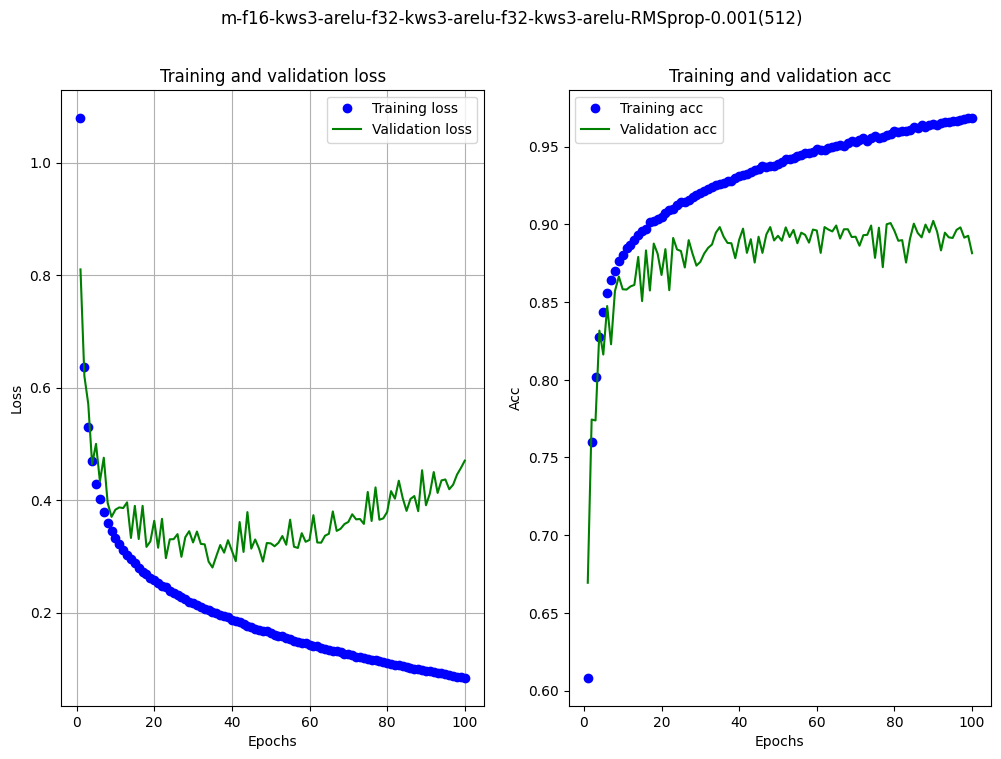

In [152]:
model_6 = retest_NN(
                    filters=[16, 32, 32, 32], 
                    windows=[3, 3, 3],
                    act=['relu' for _ in range(4)],  # mish sigmoid
                    opt=optimizers.legacy.RMSprop,  # Adadelta Adam
                    lr=0.001,
                    bs=512,
                    epochs=100
                    )

З 35-ї епохи помітний початок `перенавчання`, тренувальні - loss: 0.2015 - accuracy: 0.9257, валідаційні - val_loss: 0.2802 - `val_accuracy`: __0.8982 __.<br>
3.25 c тренування на епоху.

За розширення вікна згортки з 3 до 9, враховуючи малий розмір вихідних зображень - довелося зменшити кількість груп шарів до 1.

Epoch 1/100
118/118 [==============================] - 4s 29ms/step - loss: 0.6733 - accuracy: 0.7623 - categorical_accuracy: 0.7623 - val_loss: 0.5194 - val_accuracy: 0.8078 - val_categorical_accuracy: 0.8078
Epoch 2/100
118/118 [==============================] - 3s 28ms/step - loss: 0.4100 - accuracy: 0.8540 - categorical_accuracy: 0.8540 - val_loss: 0.5006 - val_accuracy: 0.8270 - val_categorical_accuracy: 0.8270
Epoch 3/100
118/118 [==============================] - 3s 29ms/step - loss: 0.3451 - accuracy: 0.8746 - categorical_accuracy: 0.8746 - val_loss: 0.3737 - val_accuracy: 0.8650 - val_categorical_accuracy: 0.8650
Epoch 4/100
118/118 [==============================] - 3s 28ms/step - loss: 0.3107 - accuracy: 0.8861 - categorical_accuracy: 0.8861 - val_loss: 0.4326 - val_accuracy: 0.8436 - val_categorical_accuracy: 0.8436
Epoch 5/100
118/118 [==============================] - 3s 28ms/step - loss: 0.2833 - accuracy: 0.8964 - categorical_accuracy: 0.8964 - val_loss: 0.3877 - val_ac

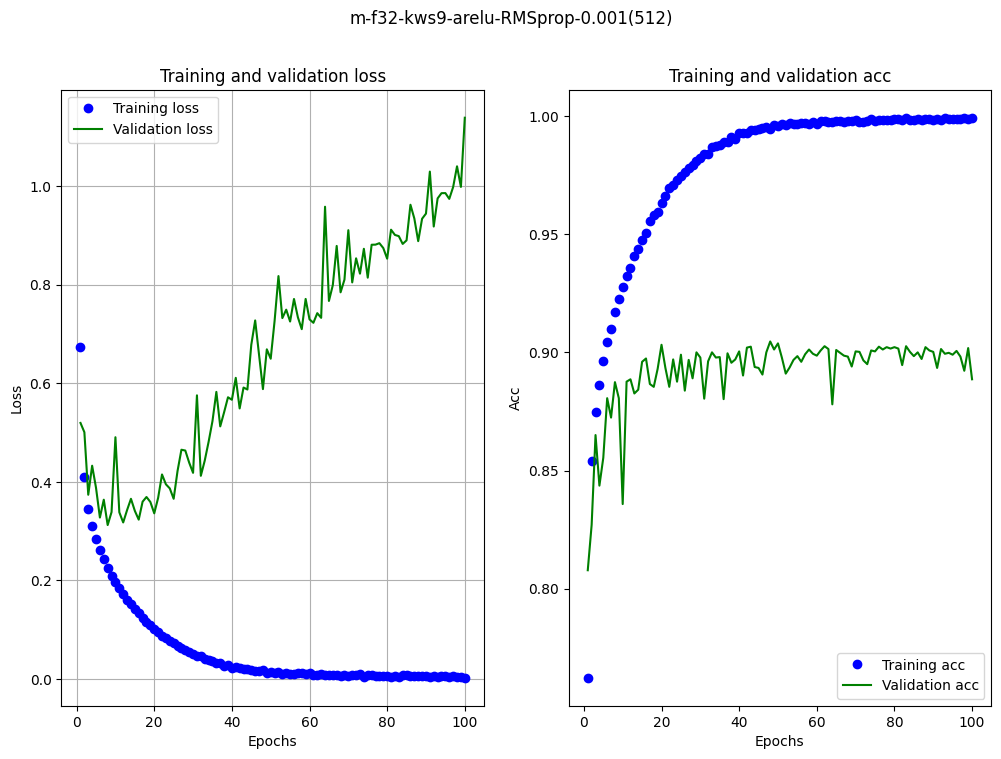

In [154]:
model_7 = retest_NN(
                    filters=[32, 64], 
                    windows=[9 ],
                    act=['relu' for _ in range(4)],  # mish sigmoid
                    opt=optimizers.legacy.RMSprop,  # Adadelta Adam
                    lr=0.001,
                    bs=512,
                    epochs=100
                    )

Десь з 12-ї епохи помітний початок `перенавчання`, тренувальні - loss: 0.1729 - accuracy: 0.9358, валідаційної - val_loss: 0.3175 - val_accuracy: __0.8886__.<br>
3.3 c тренування на епоху.

Збільшимо кількість фільтрів на шарах:

Epoch 1/100
118/118 [==============================] - 21s 171ms/step - loss: 0.8499 - accuracy: 0.6958 - categorical_accuracy: 0.6958 - val_loss: 0.6263 - val_accuracy: 0.7614 - val_categorical_accuracy: 0.7614
Epoch 2/100
118/118 [==============================] - 20s 170ms/step - loss: 0.4655 - accuracy: 0.8261 - categorical_accuracy: 0.8261 - val_loss: 0.5393 - val_accuracy: 0.8122 - val_categorical_accuracy: 0.8122
Epoch 3/100
118/118 [==============================] - 20s 169ms/step - loss: 0.3699 - accuracy: 0.8642 - categorical_accuracy: 0.8642 - val_loss: 0.4410 - val_accuracy: 0.8300 - val_categorical_accuracy: 0.8300
Epoch 4/100
118/118 [==============================] - 20s 168ms/step - loss: 0.3177 - accuracy: 0.8835 - categorical_accuracy: 0.8835 - val_loss: 0.4757 - val_accuracy: 0.8154 - val_categorical_accuracy: 0.8154
Epoch 5/100
118/118 [==============================] - 20s 169ms/step - loss: 0.2849 - accuracy: 0.8952 - categorical_accuracy: 0.8952 - val_loss: 0.388

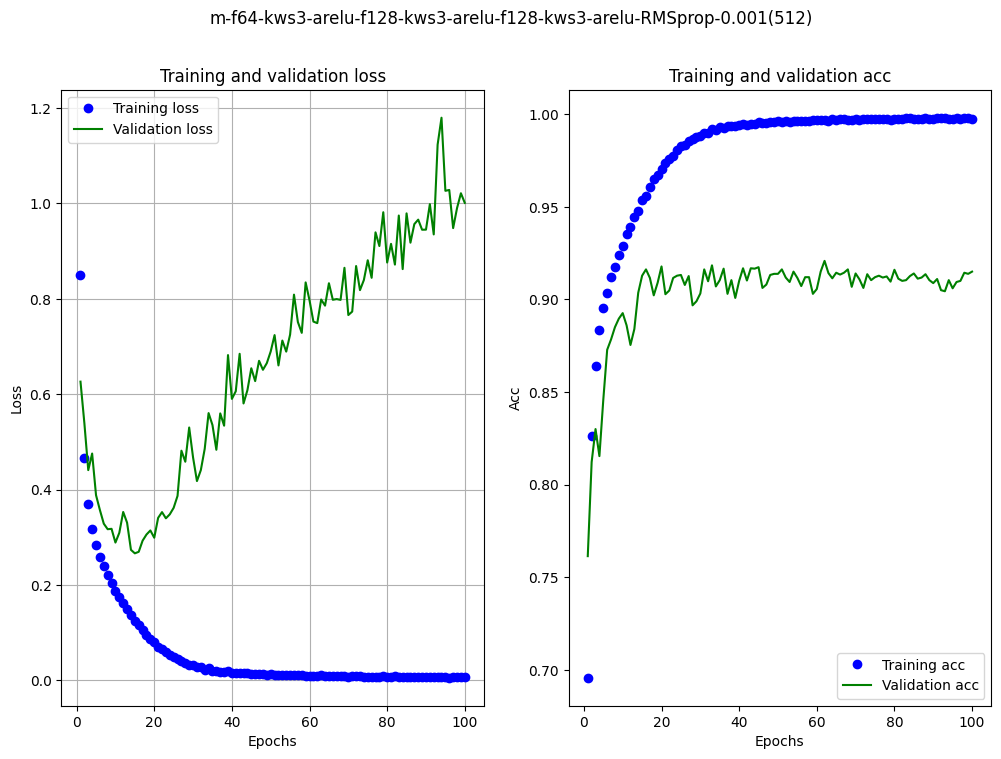

In [158]:
model_8 = retest_NN(
                    filters=[64, 128, 128, 128], 
                    windows=[3, 3, 3],
                    act=['relu' for _ in range(4)],  # mish sigmoid
                    opt=optimizers.legacy.RMSprop,  # Adadelta Adam
                    lr=0.001,
                    bs=512,
                    epochs=100
                    )

Десь з 15-ї епохи помітний початок `перенавчання`, тренувальні - loss: 0.1246 - accuracy: 0.9535, валідаційні - val_loss: 0.2665 - `val_accuracy`: __0.9128__.<br>
20.17 c тренування на епоху.

##### __Сonclusions 0__

Аналізуючи вищенаведені варіанти:

- збільшення кількості фільтрів на шарах сприяє швидшому перенавчаню, та ледь-помітному покращенню валідаційної точності, але час тренування значно триваліший.
- за розширення вікна згортки з 3 до 9, і зменшення кількість груп шарів до 1 - пришвидшує тренування, прискорює перенавання і погіршує валідаційну точність.
- зменшення кількості фільтрів - сприяє уповільненню перенавчання, прискоренню тренування і незначному зниженні валідаційної точності.
- за розширення вікна згортки з 3 до 5, і зменшенні кількість груп шарів - трішки прискорює перенавання і покращує валідаційну точність.
- збільшення розміру батчів майже не вплинуло - уповільнює перенавчання і трішки прискорює тренування, з незначним покращенням валідаційної точності.
- збільшуючи рейтинг-швидкості навчання (`lr`) - трішки уповільнює перенавчання, і трішки погіршує валідаційну точність, втрати - зросли.
- зміна опримізатора на Adam - трішки уповільнило перенавчання, незначно підвищило валідаційну точніть, але і втрати на валідаційній вибірці.
- заміна `relu` на `sigmoid` -трішки погіршила валідаційну точність, і значно уповільнило перенавчання (98 епоха, якщо не пізніше), схоже на недонавчання.
<br><br>
Тому, спробуємо:

Epoch 1/200
59/59 [==============================] - 24s 407ms/step - loss: 0.9327 - accuracy: 0.6646 - categorical_accuracy: 0.6646 - val_loss: 0.5963 - val_accuracy: 0.7712 - val_categorical_accuracy: 0.7712
Epoch 2/200
59/59 [==============================] - 24s 401ms/step - loss: 0.5458 - accuracy: 0.7968 - categorical_accuracy: 0.7968 - val_loss: 0.4673 - val_accuracy: 0.8300 - val_categorical_accuracy: 0.8300
Epoch 3/200
59/59 [==============================] - 24s 398ms/step - loss: 0.4490 - accuracy: 0.8366 - categorical_accuracy: 0.8366 - val_loss: 0.4424 - val_accuracy: 0.8378 - val_categorical_accuracy: 0.8378
Epoch 4/200
59/59 [==============================] - 24s 401ms/step - loss: 0.3906 - accuracy: 0.8588 - categorical_accuracy: 0.8588 - val_loss: 0.3964 - val_accuracy: 0.8594 - val_categorical_accuracy: 0.8594
Epoch 5/200
59/59 [==============================] - 24s 401ms/step - loss: 0.3535 - accuracy: 0.8722 - categorical_accuracy: 0.8722 - val_loss: 0.3751 - val_ac

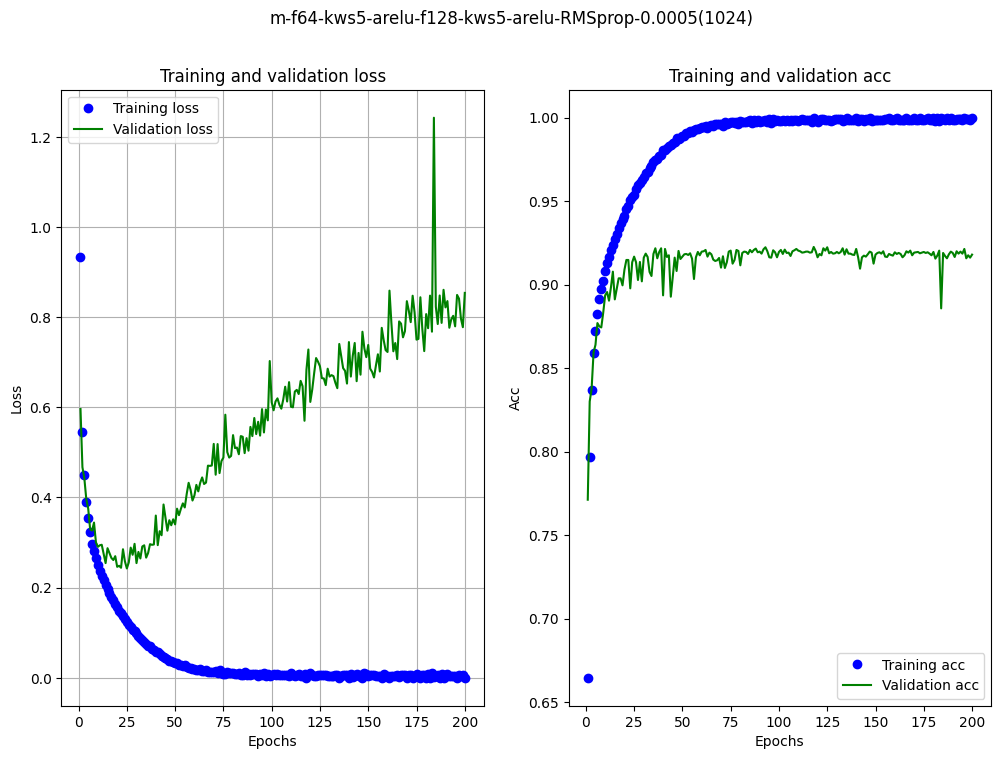

In [160]:
model_8 = retest_NN(
                    filters=[64, 128, 128], 
                    windows=[5, 5],
                    act=['relu' for _ in range(3)],
                    opt=optimizers.legacy.RMSprop,
                    lr=0.0005,
                    bs=1024,
                    epochs=200
                    )

З 25-ї епохи помітний початок `перенавчання`, тренувальні - loss: 0.1248 - accuracy: 0.9540, валідаційні - val_loss: 0.2425 - `val_accuracy`: __0.9168 __.<br>
24 c тренування на епоху.

Epoch 1/70
59/59 [==============================] - 24s 406ms/step - loss: 0.9285 - accuracy: 0.6690 - categorical_accuracy: 0.6690 - val_loss: 0.7663 - val_accuracy: 0.7126 - val_categorical_accuracy: 0.7126
Epoch 2/70
59/59 [==============================] - 25s 416ms/step - loss: 0.5016 - accuracy: 0.8167 - categorical_accuracy: 0.8167 - val_loss: 0.4873 - val_accuracy: 0.8182 - val_categorical_accuracy: 0.8182
Epoch 3/70
59/59 [==============================] - 24s 403ms/step - loss: 0.3912 - accuracy: 0.8590 - categorical_accuracy: 0.8590 - val_loss: 0.3764 - val_accuracy: 0.8558 - val_categorical_accuracy: 0.8558
Epoch 4/70
59/59 [==============================] - 24s 400ms/step - loss: 0.3363 - accuracy: 0.8779 - categorical_accuracy: 0.8779 - val_loss: 0.3773 - val_accuracy: 0.8556 - val_categorical_accuracy: 0.8556
Epoch 5/70
59/59 [==============================] - 24s 402ms/step - loss: 0.2997 - accuracy: 0.8901 - categorical_accuracy: 0.8901 - val_loss: 0.3122 - val_accurac

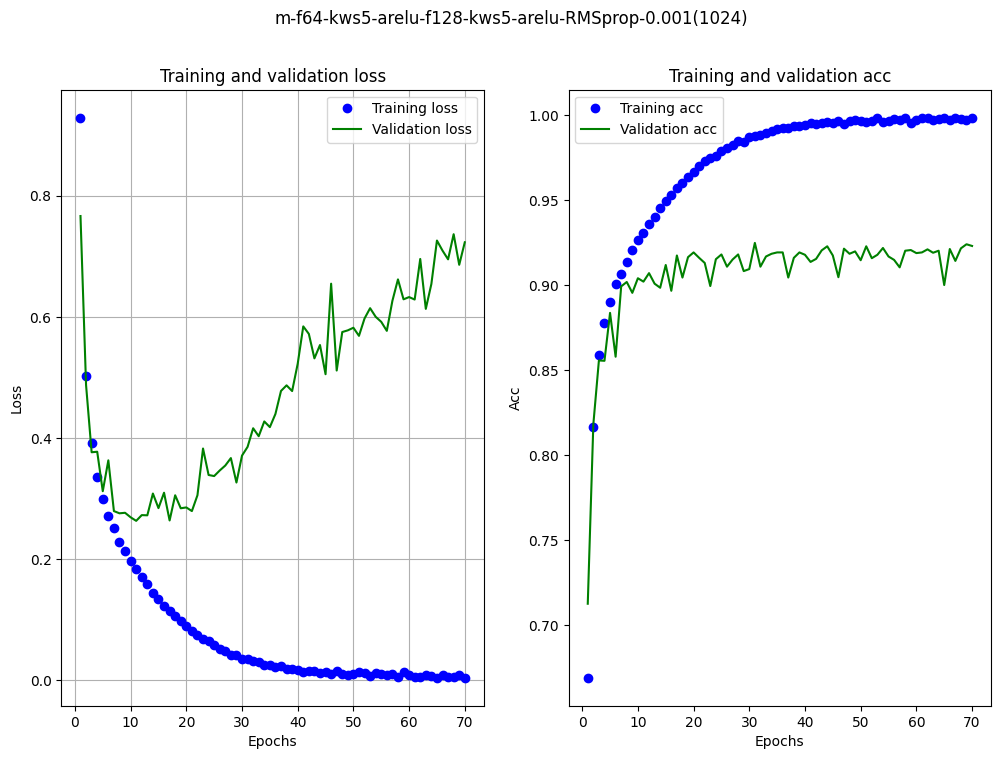

In [163]:
model_9 = retest_NN(
                    filters=[64, 128, 128], 
                    windows=[5, 5],
                    act=['relu' for _ in range(3)],
                    opt=optimizers.legacy.RMSprop,
                    lr=0.001,
                    bs=1024,
                    epochs=70
                    )

З 17-ї епохи помітний початок `перенавчання`, тренувальні - loss: 0.1137 - accuracy: 0.9573, валідаційні - val_loss: 0.2639 - `val_accuracy`: __0.9176__.<br>
24.4 c тренування на епоху.


In [165]:
test_loss, test_acc, test_acc_category = model_9.evaluate(images_test, labels_test)
print(test_acc)

  1/157 [..............................] - ETA: 3s - loss: 0.7973 - accuracy: 0.9375 - categorical_accuracy: 0.9375

157/157 [==============================] - 1s 7ms/step - loss: 0.7533 - accuracy: 0.9182 - categorical_accuracy: 0.9182
0.9182000160217285


більше 95% на тренувальних, та більше 91% на валідаційних та тестових даних.

In [ ]:
# !!!!!!!!! + 60K to 6K input data
model_10 = retest_NN(
                     filters=[64, 128, 128], 
                     windows=[5, 5],
                     act=['relu' for _ in range(3)],
                     opt=optimizers.legacy.RMSprop,
                     lr=0.001,
                     bs=20,
                     epochs=70
                     )

##### __Сonclusions 1__

Загалом для даного датасету (зображення 28*28) великої кількості шарів(згорток) не потрібно, бо неможливо виділити(знайти бо й розмістити) біль конкретні ознаки на малому розміру початкових зображень. Так само через це просто не можна застосовувати відносно великі матриці згорток. Згорткова нейромережа дуже підходяща для завдань розпізнавання образів, і має загалом кращі результати точності ніж звичайна багатошарова повнозв'язна мережа (в порівнянні з результатами попереднього завдання 0.8995 проти 0.9182). Налаштування (гіперпараметри) так само можуть сильно впливати на результати як і в інших моделях мереж, властиві як перенавчання так і недонавчання. Тому - як завжди: треба підбирати гіперпараметри ждя кожного конкретного випадку (датасету).

# __Part 2__

`VGG16` в якості згорткової основи.

Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти `максимально можливої точності класифікації` за рахунок `маніпуляції параметрами` мережі. Під час навчання використовуйте `прийоми донавчання` та `виділення ознак`.

##### __Dataset__ (from Part 1)

In [13]:
images_train.shape, images_test.shape, images_valid.shape, labels_train.shape, labels_test.shape, labels_valid.shape

((60000, 28, 28),
 (5000, 28, 28),
 (5000, 28, 28),
 (60000, 10),
 (5000, 10),
 (5000, 10))

In [28]:
images_train[0].shape

(28, 28)

- https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/#gsc.tab=0
- https://stackoverflow.com/questions/64276472/valueerror-the-input-must-have-3-channels-got-input-shape-200-200-1

In [112]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, X, y, shuffle=True, batch_size=256, to_size=32):
        self.X = X  # (60000, 28, 28)
        self.y = y  # (60000, 10)
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        self.batch_size = batch_size
        self.to_size = to_size
        
        if shuffle:
            self.on_epoch_end()
    
    def __len__(self):
        return math.ceil(self.y.shape[0] / self.batch_size)
    
    def __getitem__(self, idx):  # idx = batche's numder
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]

        batch_X_row = [self.X[i] for i in indexes]
        batch_y = [self.y[i] for i in indexes]

        # cv2.cvtColor(grayscale_image, cv2.COLOR_GRAY2RGB)
        batch_X = [cv2.cvtColor(cv2.resize(img, (self.to_size, self.to_size), interpolation=cv2.INTER_NEAREST), cv2.COLOR_GRAY2RGB) for img in batch_X_row]

        return np.array(batch_X), np.array(batch_y)
        
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [134]:
batch_size = 512

In [135]:
train_datagen = Dataset(X=images_train, y=labels_train, batch_size=batch_size)  # to_size=48
train_datagen[0][0].shape


(512, 32, 32, 3)

In [136]:
valid_datagen = Dataset(X=images_valid, y=labels_valid, batch_size=1) 

##### __Model__

- https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- https://stackoverflow.com/questions/64276472/valueerror-the-input-must-have-3-channels-got-input-shape-200-200-1

In [130]:
conv_base = VGG16(
                  include_top=False,  # False = own data-classifier, not built-in
                  weights='imagenet',  # source of weights for model initialization
                  # input_tensor=None,  # optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model. 
                  input_shape=(train_datagen[0][0].shape[1], train_datagen[0][0].shape[2], 3),  # optional shape tuple
                  # pooling=None,  # Optional pooling
                  # classes=10,
                  # classifier_activation='softmax'
                  )

conv_base.trainable = False

model = Sequential([
                    conv_base,
                    layers.Flatten(),
                    layers.Dense(256, activation='relu'),
                    layers.Dense(NUM_CLASSES, activation='softmax'),
                    ])

model.compile(
              loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy']
              )

##### __Training__

In [131]:
history = model.fit(
                    train_datagen,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_data=valid_datagen,
                    validation_steps=100
                    )

Epoch 1/100


100/100 [==============================] - 3s 29ms/step - loss: 2.3239 - accuracy: 0.1500 - val_loss: 2.3082 - val_accuracy: 0.1900
Epoch 2/100
100/100 [==============================] - 3s 27ms/step - loss: 2.1200 - accuracy: 0.2700 - val_loss: 1.9909 - val_accuracy: 0.2600
Epoch 3/100
100/100 [==============================] - 3s 26ms/step - loss: 2.0061 - accuracy: 0.3300 - val_loss: 1.8674 - val_accuracy: 0.4100
Epoch 4/100
100/100 [==============================] - 3s 27ms/step - loss: 1.9349 - accuracy: 0.3600 - val_loss: 1.7316 - val_accuracy: 0.5600
Epoch 5/100
100/100 [==============================] - 3s 26ms/step - loss: 1.7485 - accuracy: 0.5200 - val_loss: 1.6968 - val_accuracy: 0.5100
Epoch 6/100
100/100 [==============================] - 3s 27ms/step - loss: 1.6264 - accuracy: 0.5500 - val_loss: 1.5990 - val_accuracy: 0.5800
Epoch 7/100
100/100 [==============================] - 3s 27ms/step - loss: 1.5379 - accuracy: 0.5300 - val_loss: 1.3959 - val_accuracy: 0.6600
Epoc

##### __Error Analysis__

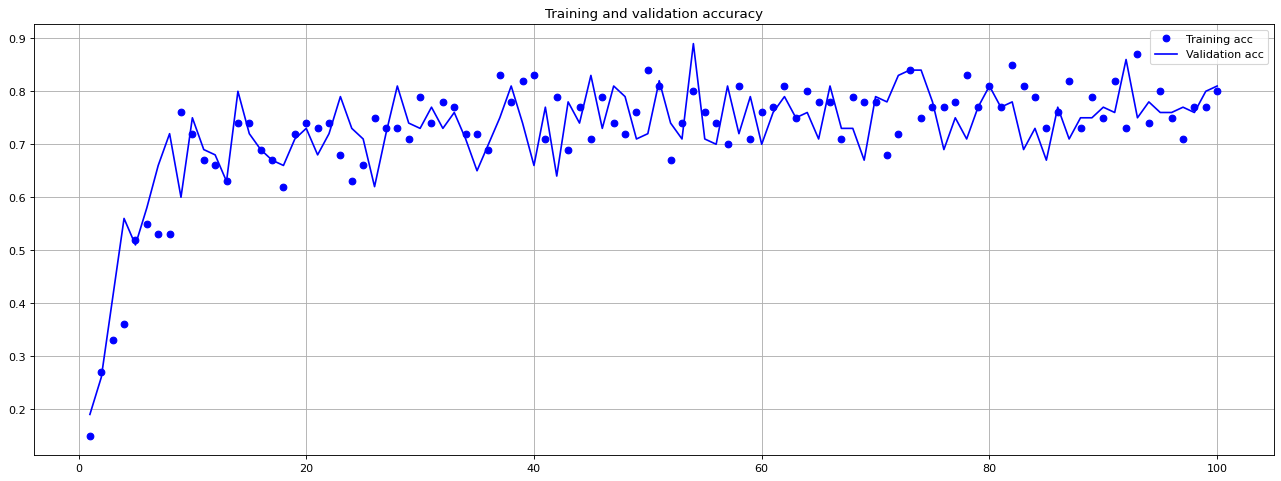

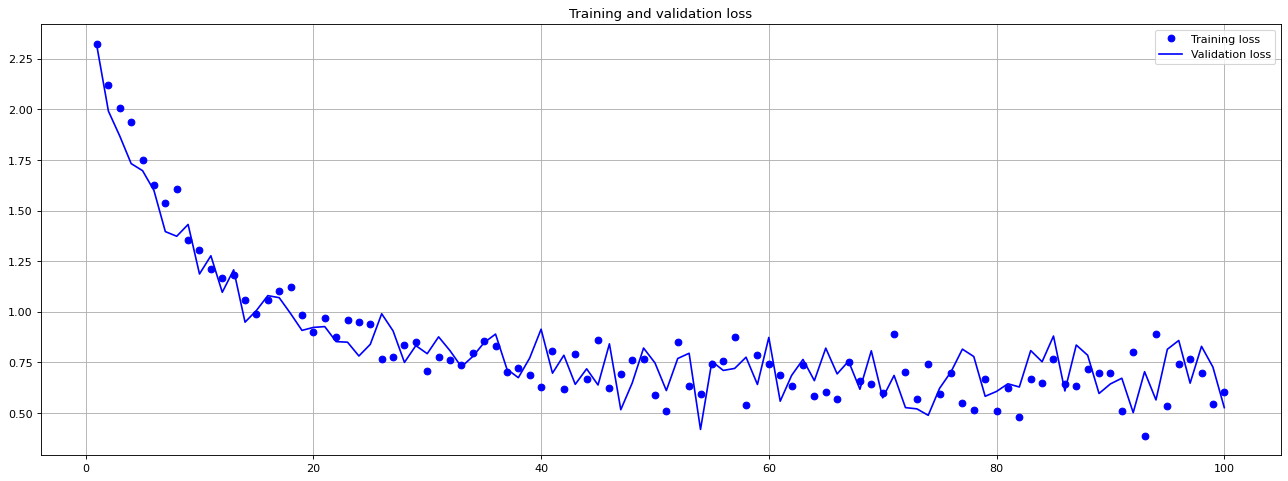

In [133]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')

plt.legend()
plt.show()

##### __repeating__

In [150]:
def create_NNplus(number_pre_final_n: int, activation: str, optimizer=optimizers.SGD, learning_rate=0.1) -> Sequential:
    m = train_datagen[0][0].shape[1]
    n = train_datagen[0][0].shape[2]
    
    conv_base = VGG16(
                      include_top=False,  # False = own data-classifier, not built-in
                      weights='imagenet',  # source of weights for model initialization
                      input_shape=(m, n, 3),  # optional shape tuple
                      )

    conv_base.trainable = False

    model = Sequential([
                        conv_base,
                        layers.Flatten(),
                        layers.Dense(number_pre_final_n, activation=activation),
                        layers.Dense(NUM_CLASSES, activation='softmax'),
                        ],
                        name=f'm-{number_pre_final_n}_act-{activation}_input-size-{m}-x-{n}_{optimizer.__name__}_{learning_rate}'
                        )

    model.compile(
                loss='categorical_crossentropy',  # losses.CategoricalCrossentropy()
                optimizer=optimizer(learning_rate=learning_rate), # legacy
                # optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                metrics=['accuracy']  # metrics.CategoricalAccuracy()
                )

    return model

In [175]:
def retest_NNplus(number_pre_final_n: int, act: str, opt: optimizers, lr: float, bs: int, epochs: int=100, steps: int=100) -> Sequential:
    """For retest one model."""
    train_datagen = Dataset(X=images_train, y=labels_train, batch_size=bs)  # to_size=48
    valid_datagen = Dataset(X=images_valid, y=labels_valid, batch_size=1) 

    models = [create_NNplus(
                            number_pre_final_n=number_pre_final_n, 
                            activation=act, 
                            optimizer=opt, 
                            learning_rate=lr
                            )]

    callback_save = ModelCheckpoint(
                                    'best.hdf5',
                                    monitor='val_loss',
                                    save_best_only=True,
                                    )
    
    callback_early_stopping = EarlyStopping(
                                            monitor='val_accuracy',
                                            patience=6,
                                            verbose=0,
                                            mode='max',
                                            )
    
    history = {}
    history[f'{models[0].name}({bs})'] = models[0].fit(
                                                       train_datagen,
                                                       steps_per_epoch=steps,
                                                       epochs=epochs,
                                                       validation_data=valid_datagen,
                                                       validation_steps=steps,
                                                       callbacks=[callback_early_stopping, callback_save]
                                                       )

    for model in history:
        history_dict = history[model].history

        loss_values = history_dict['loss']
        val_loss_values = history_dict['val_loss']
        acc_values = history_dict['accuracy']
        val_acc_values = history_dict['val_accuracy']   

        draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=model)

    return models[0]

Epoch 1/100
50/50 [==============================] - 61s 1s/step - loss: 2.1209 - accuracy: 0.2850 - val_loss: 1.8976 - val_accuracy: 0.3800
Epoch 2/100
50/50 [==============================] - 60s 1s/step - loss: 1.6717 - accuracy: 0.5971 - val_loss: 1.4889 - val_accuracy: 0.6600
Epoch 3/100
50/50 [==============================] - 60s 1s/step - loss: 1.3473 - accuracy: 0.6771 - val_loss: 1.1361 - val_accuracy: 0.7200
Epoch 4/100
50/50 [==============================] - 60s 1s/step - loss: 1.1154 - accuracy: 0.7189 - val_loss: 0.8944 - val_accuracy: 0.7800
Epoch 5/100
50/50 [==============================] - 61s 1s/step - loss: 0.9596 - accuracy: 0.7390 - val_loss: 0.8613 - val_accuracy: 0.7800
Epoch 6/100
50/50 [==============================] - 60s 1s/step - loss: 0.8485 - accuracy: 0.7559 - val_loss: 0.8386 - val_accuracy: 0.7000
Epoch 7/100
50/50 [==============================] - 60s 1s/step - loss: 0.7796 - accuracy: 0.7612 - val_loss: 0.7367 - val_accuracy: 0.7600
Epoch 8/100
5

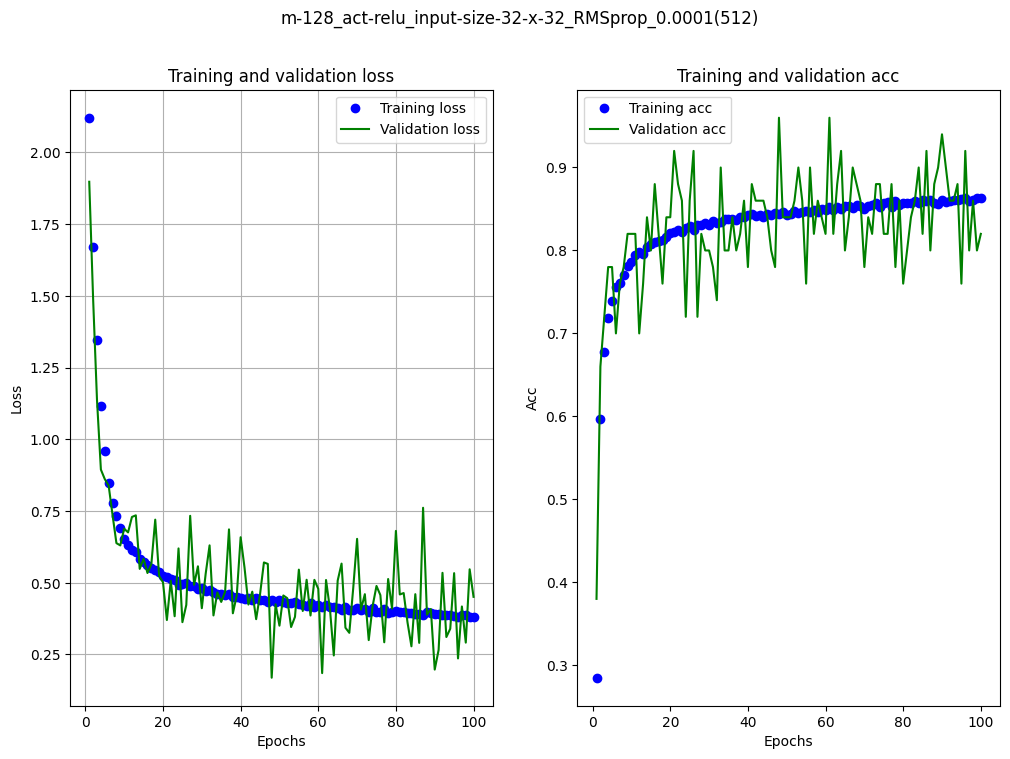

In [155]:
modelp_0 = retest_NNplus(
                         number_pre_final_n=128,
                         act='relu',
                         opt=optimizers.legacy.RMSprop,
                         lr=1e-4,
                         bs=512,
                         epochs=100,
                         steps=50
                         )

In [154]:
modelp_0.summary()

Model: "m-256_act-relu_input-size-32-x-32_RMSprop_0.0001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


Epoch 1/10
50/50 [==============================] - 116s 2s/step - loss: 1.0660 - accuracy: 0.6587 - val_loss: 0.7717 - val_accuracy: 0.7200
Epoch 2/10
50/50 [==============================] - 115s 2s/step - loss: 0.6026 - accuracy: 0.7826 - val_loss: 0.6881 - val_accuracy: 0.7000
Epoch 3/10
50/50 [==============================] - 115s 2s/step - loss: 0.5377 - accuracy: 0.8028 - val_loss: 0.5952 - val_accuracy: 0.8200
Epoch 4/10
50/50 [==============================] - 115s 2s/step - loss: 0.4943 - accuracy: 0.8196 - val_loss: 0.6175 - val_accuracy: 0.7800
Epoch 5/10
50/50 [==============================] - 115s 2s/step - loss: 0.4719 - accuracy: 0.8269 - val_loss: 0.3629 - val_accuracy: 0.8800
Epoch 6/10
50/50 [==============================] - 115s 2s/step - loss: 0.4503 - accuracy: 0.8341 - val_loss: 0.6182 - val_accuracy: 0.7800
Epoch 7/10
50/50 [==============================] - 115s 2s/step - loss: 0.4340 - accuracy: 0.8399 - val_loss: 0.1592 - val_accuracy: 0.9600
Epoch 8/10
50

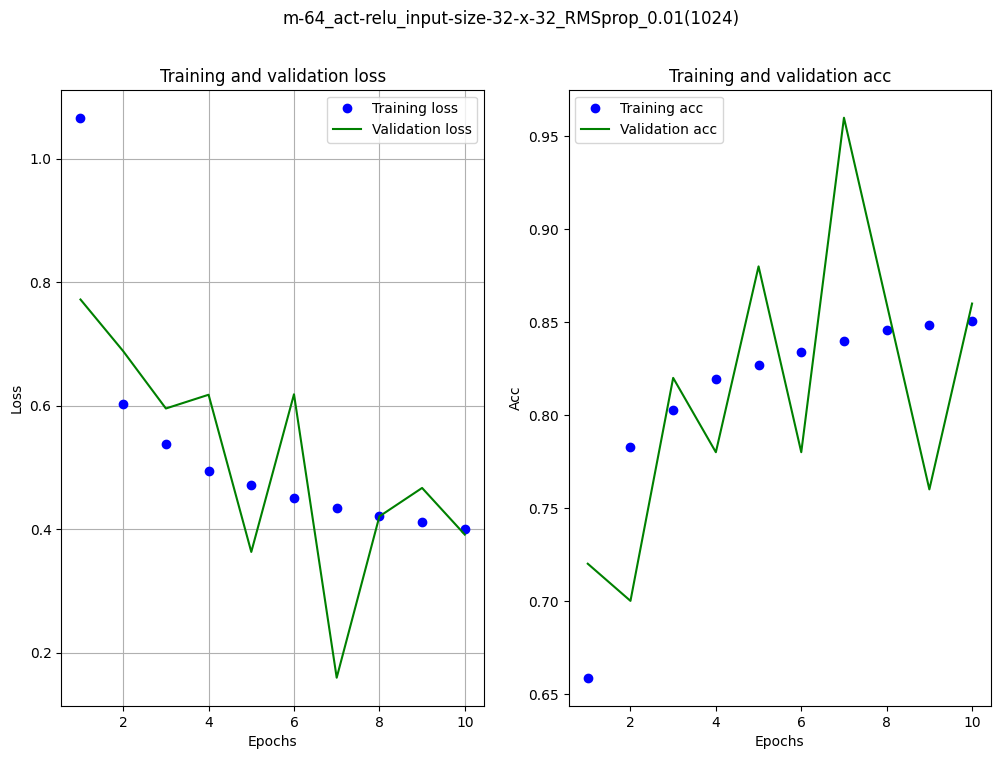

In [159]:
modelp_1 = retest_NNplus(
                         number_pre_final_n=64,
                         act='relu',
                         opt=optimizers.legacy.RMSprop,
                         lr=1e-2,
                         bs=1024,
                         epochs=10,
                         steps=50
                         )

Досить непоганий результат на 7й епосі: тренувальна - loss: 0.4340 - accuracy: 0.8399, валідаційна -  val_loss: 0.1592 - `val_accuracy`: __0.9600__

Epoch 1/10
50/50 [==============================] - 117s 2s/step - loss: 1.0226 - accuracy: 0.6662 - val_loss: 0.6701 - val_accuracy: 0.7800
Epoch 2/10
50/50 [==============================] - 118s 2s/step - loss: 0.6049 - accuracy: 0.7802 - val_loss: 0.5263 - val_accuracy: 0.8000
Epoch 3/10
50/50 [==============================] - 116s 2s/step - loss: 0.5343 - accuracy: 0.8029 - val_loss: 0.8145 - val_accuracy: 0.6800
Epoch 4/10
50/50 [==============================] - 116s 2s/step - loss: 0.4955 - accuracy: 0.8180 - val_loss: 0.3451 - val_accuracy: 0.8800
Epoch 5/10
50/50 [==============================] - 116s 2s/step - loss: 0.4642 - accuracy: 0.8282 - val_loss: 0.3637 - val_accuracy: 0.8200
Epoch 6/10
50/50 [==============================] - 116s 2s/step - loss: 0.4467 - accuracy: 0.8344 - val_loss: 0.3248 - val_accuracy: 0.8600
Epoch 7/10
50/50 [==============================] - 114s 2s/step - loss: 0.4314 - accuracy: 0.8392 - val_loss: 0.3512 - val_accuracy: 0.9000
Epoch 8/10
50

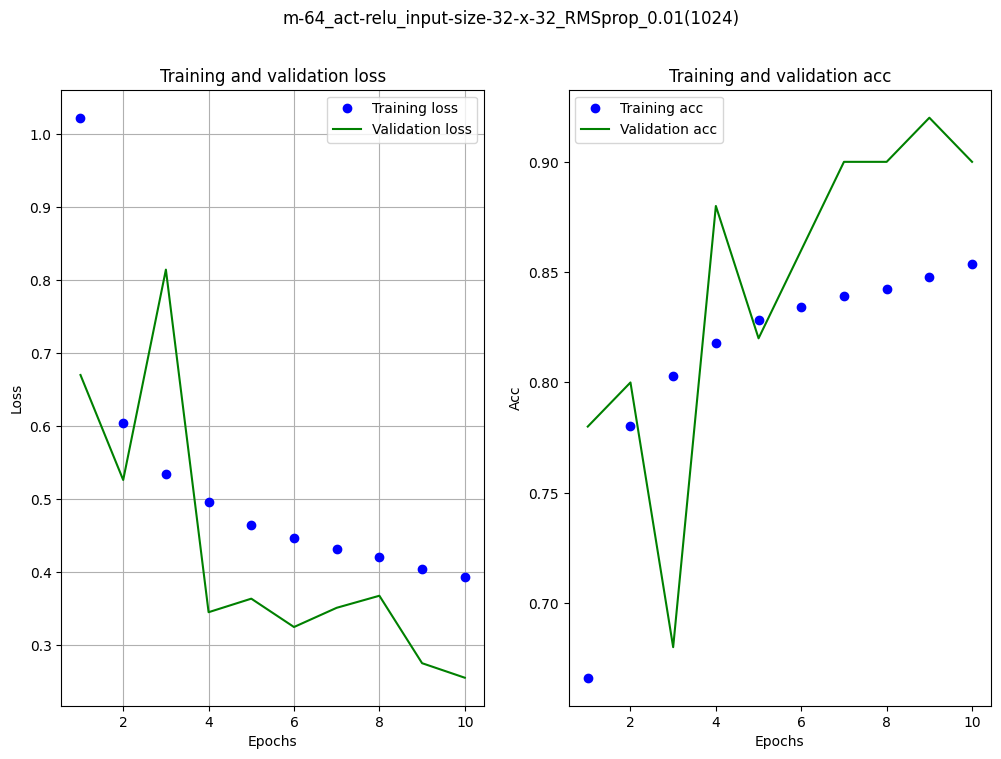

In [168]:
modelp_2 = retest_NNplus(
                         number_pre_final_n=64,
                         act='relu',
                         opt=optimizers.legacy.RMSprop,
                         lr=1e-2,
                         bs=1024,
                         epochs=10,
                         steps=50
                         )

In [169]:
model = keras.models.load_model('best.hdf5')
test_dataset = Dataset(X=images_test, y=labels_test, batch_size=1) 
test_loss, test_acc = model.evaluate(test_dataset)
print(test_loss, test_acc)

5000/5000 [==============================] - 76s 15ms/step - loss: 0.4346 - accuracy: 0.8388
0.43462803959846497 0.8388000130653381


За други запуском нової моделі з тимиж параметрами:<br>
на 9й епосі - loss: 0.4042 - accuracy: 0.8477 - val_loss: 0.2753 - `val_accuracy`: __0.9200__
а тестової вибірки: loss: 0.43462, accuracy: __0.83880__

Epoch 1/20
50/50 [==============================] - 117s 2s/step - loss: 2.3060 - accuracy: 0.1753 - val_loss: 2.2098 - val_accuracy: 0.2200
Epoch 2/20
50/50 [==============================] - 117s 2s/step - loss: 2.1415 - accuracy: 0.2777 - val_loss: 2.0723 - val_accuracy: 0.3200
Epoch 3/20
50/50 [==============================] - 116s 2s/step - loss: 2.0000 - accuracy: 0.3768 - val_loss: 1.9321 - val_accuracy: 0.4600
Epoch 4/20
50/50 [==============================] - 116s 2s/step - loss: 1.8704 - accuracy: 0.4877 - val_loss: 1.7948 - val_accuracy: 0.6600
Epoch 5/20
50/50 [==============================] - 116s 2s/step - loss: 1.7514 - accuracy: 0.5673 - val_loss: 1.8136 - val_accuracy: 0.4600
Epoch 6/20
50/50 [==============================] - 116s 2s/step - loss: 1.6372 - accuracy: 0.6147 - val_loss: 1.6206 - val_accuracy: 0.7200
Epoch 7/20
50/50 [==============================] - 116s 2s/step - loss: 1.5299 - accuracy: 0.6432 - val_loss: 1.5874 - val_accuracy: 0.5600
Epoch 8/20
50

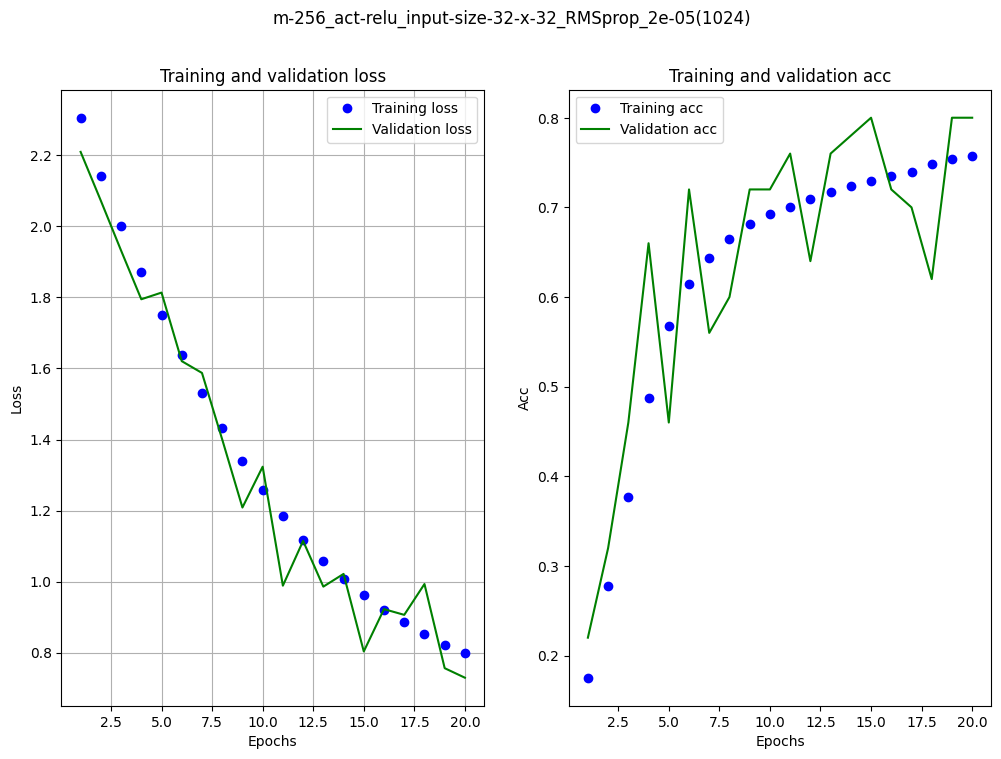

In [178]:
modelp_3 = retest_NNplus(
                         number_pre_final_n=256,
                         act='relu',
                         opt=optimizers.legacy.RMSprop,
                         lr=2e-5,
                         bs=1024,
                         epochs=20,
                         steps=50
                         )

In [179]:
model = keras.models.load_model('best.hdf5')
test_dataset = Dataset(X=images_test, y=labels_test, batch_size=1) 
test_loss, test_acc = model.evaluate(test_dataset)
print(test_loss, test_acc)

5000/5000 [==============================] - 76s 15ms/step - loss: 0.8051 - accuracy: 0.7476
0.8051044344902039 0.7476000189781189


Epoch 1/20
50/50 [==============================] - 62s 1s/step - loss: 1.8712 - accuracy: 0.4470 - val_loss: 1.3758 - val_accuracy: 0.7200
Epoch 2/20
50/50 [==============================] - 61s 1s/step - loss: 1.1973 - accuracy: 0.7041 - val_loss: 0.9346 - val_accuracy: 0.7600
Epoch 3/20
50/50 [==============================] - 61s 1s/step - loss: 0.8933 - accuracy: 0.7447 - val_loss: 0.7547 - val_accuracy: 0.8200
Epoch 4/20
50/50 [==============================] - 63s 1s/step - loss: 0.7364 - accuracy: 0.7724 - val_loss: 0.7547 - val_accuracy: 0.7600
Epoch 5/20
50/50 [==============================] - 62s 1s/step - loss: 0.6654 - accuracy: 0.7859 - val_loss: 0.6944 - val_accuracy: 0.7600
Epoch 6/20
50/50 [==============================] - 62s 1s/step - loss: 0.6154 - accuracy: 0.7955 - val_loss: 0.5095 - val_accuracy: 0.8600
Epoch 7/20
50/50 [==============================] - 61s 1s/step - loss: 0.5881 - accuracy: 0.8028 - val_loss: 0.7701 - val_accuracy: 0.7400
Epoch 8/20
50/50 [==

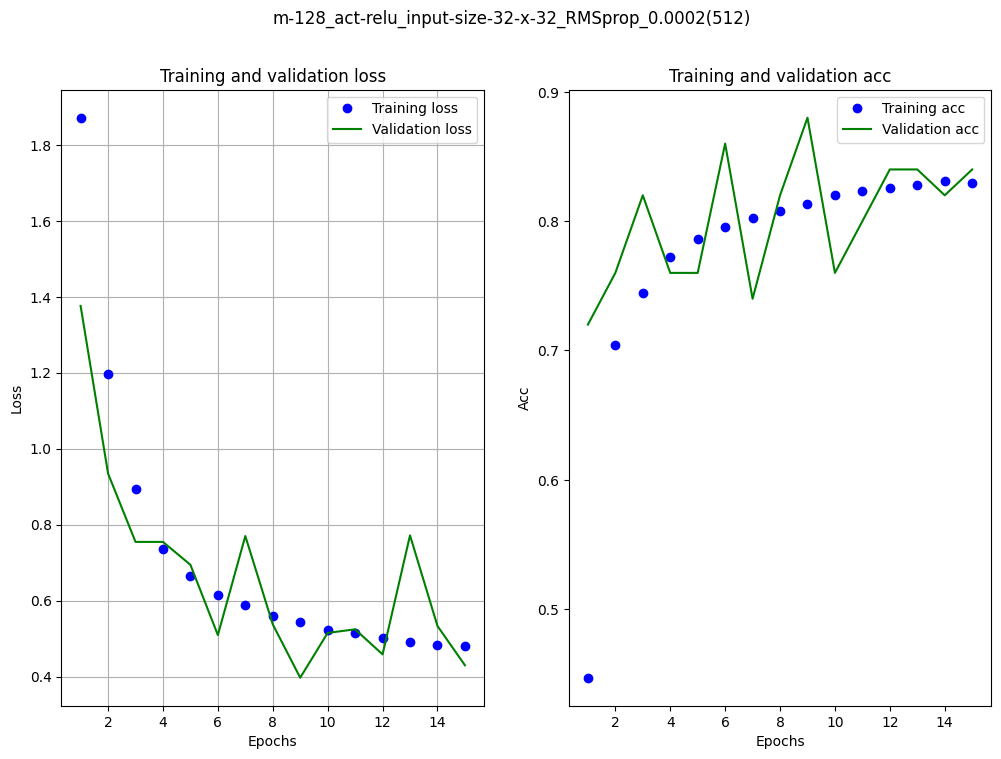

In [180]:
modelp_4 = retest_NNplus(
                         number_pre_final_n=128,
                         act='relu',
                         opt=optimizers.legacy.RMSprop,
                         lr=2e-4,
                         bs=512,
                         epochs=20,
                         steps=50
                         )

In [181]:
model = keras.models.load_model('best.hdf5')
test_dataset = Dataset(X=images_test, y=labels_test, batch_size=1) 
test_loss, test_acc = model.evaluate(test_dataset)
print(test_loss, test_acc)

5000/5000 [==============================] - 74s 15ms/step - loss: 0.5532 - accuracy: 0.8084
0.5531637072563171 0.8083999752998352


Результати невражаючі. Застосуємо донавчання.

In [184]:
def create_NNplus3(
                   number_pre_final_n: int, 
                   activation: str, 
                   optimizer=optimizers.SGD, 
                   learning_rate=0.1, 
                   stop_retraining_layer: str='block5_conv1'
                   ) -> Sequential:
    m = train_datagen[0][0].shape[1]
    n = train_datagen[0][0].shape[2]
    
    conv_base = VGG16(
                      include_top=False,  # False = own data-classifier, not built-in
                      weights='imagenet',  # source of weights for model initialization
                      input_shape=(m, n, 3),  # optional shape tuple
                      )

    # conv_base.trainable = False
    conv_base.trainable = True
    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == stop_retraining_layer:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model = Sequential([
                        conv_base,
                        layers.Flatten(),
                        layers.Dense(number_pre_final_n, activation=activation),
                        layers.Dense(NUM_CLASSES, activation='softmax'),
                        ],
                        name=f'm-{number_pre_final_n}_act-{activation}_input-size-{m}-x-{n}_{optimizer.__name__}_{learning_rate}'
                        )

    model.compile(
                loss='categorical_crossentropy',  # losses.CategoricalCrossentropy()
                optimizer=optimizer(learning_rate=learning_rate), # legacy
                # optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                metrics=['accuracy']  # metrics.CategoricalAccuracy()
                )

    return model

In [185]:
def retest_NNplus3(
                   number_pre_final_n: int, 
                   act: str, 
                   opt: optimizers, 
                   lr: float, 
                   bs: int, 
                   epochs: int=100, 
                   steps: int=100, 
                   stop_retraining_layer: str='block5_conv1'
                   ) -> Sequential:
    """For retest one model."""
    train_datagen = Dataset(X=images_train, y=labels_train, batch_size=bs)  # to_size=48
    valid_datagen = Dataset(X=images_valid, y=labels_valid, batch_size=1) 

    models = [create_NNplus3(
                             number_pre_final_n=number_pre_final_n, 
                             activation=act, 
                             optimizer=opt, 
                             learning_rate=lr,
                             stop_retraining_layer=stop_retraining_layer
                             )]

    callback_save = ModelCheckpoint(
                                    'best3.hdf5',
                                    monitor='val_loss',
                                    save_best_only=True,
                                    )
    
    callback_early_stopping = EarlyStopping(
                                            monitor='val_accuracy',
                                            patience=6,
                                            verbose=0,
                                            mode='max',
                                            )
    
    history = {}
    history[f'{models[0].name}({bs})'] = models[0].fit(
                                                       train_datagen,
                                                       steps_per_epoch=steps,
                                                       epochs=epochs,
                                                       validation_data=valid_datagen,
                                                       validation_steps=steps,
                                                       callbacks=[callback_early_stopping, callback_save]
                                                       )

    for model in history:
        history_dict = history[model].history

        loss_values = history_dict['loss']
        val_loss_values = history_dict['val_loss']
        acc_values = history_dict['accuracy']
        val_acc_values = history_dict['val_accuracy']   

        draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=model)

    return models[0]

перенавчимо останні шари починаючи з 'block5_conv1':

###### model_5

Epoch 1/20
50/50 [==============================] - 79s 2s/step - loss: 0.8041 - accuracy: 0.7169 - val_loss: 0.7389 - val_accuracy: 0.7000
Epoch 2/20


/home/denys/.cache/pypoetry/virtualenvs/datas-cYPLqW4U-py3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 76s 2s/step - loss: 0.4642 - accuracy: 0.8313 - val_loss: 0.6630 - val_accuracy: 0.7200
Epoch 3/20
50/50 [==============================] - 77s 2s/step - loss: 0.3927 - accuracy: 0.8543 - val_loss: 0.3422 - val_accuracy: 0.8800
Epoch 4/20
50/50 [==============================] - 77s 2s/step - loss: 0.3557 - accuracy: 0.8662 - val_loss: 0.4596 - val_accuracy: 0.8600
Epoch 5/20
50/50 [==============================] - 76s 2s/step - loss: 0.3236 - accuracy: 0.8800 - val_loss: 0.4107 - val_accuracy: 0.8600
Epoch 6/20
50/50 [==============================] - 78s 2s/step - loss: 0.3025 - accuracy: 0.8866 - val_loss: 0.3981 - val_accuracy: 0.9000
Epoch 7/20
50/50 [==============================] - 78s 2s/step - loss: 0.2870 - accuracy: 0.8922 - val_loss: 0.3028 - val_accuracy: 0.8800
Epoch 8/20
50/50 [==============================] - 77s 2s/step - loss: 0.2758 - accuracy: 0.8945 - val_loss: 0.0836 - val_accuracy: 0.9800
Epoch 9/20
50/50 [=============

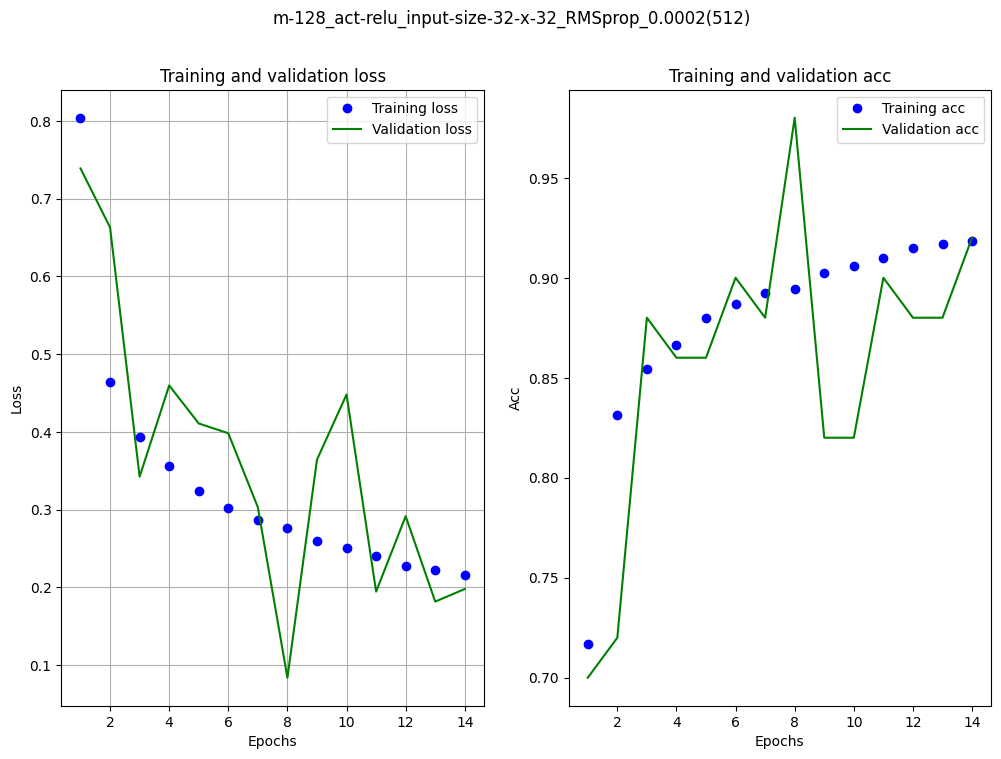

In [186]:
modelp_5 = retest_NNplus3(
                          number_pre_final_n=128,
                          act='relu',
                          opt=optimizers.legacy.RMSprop,
                          lr=2e-4,
                          bs=512,
                          epochs=20,
                          steps=50,
                          stop_retraining_layer='block5_conv1'
                          )

In [187]:
model = keras.models.load_model('best3.hdf5')
test_dataset = Dataset(X=images_test, y=labels_test, batch_size=1) 
test_loss, test_acc = model.evaluate(test_dataset)
print(test_loss, test_acc)

5000/5000 [==============================] - 70s 14ms/step - loss: 0.2953 - accuracy: 0.8876
0.29533717036247253 0.8876000046730042


Додамо ще 1 шар до перетренування.

Epoch 1/20
50/50 [==============================] - 88s 2s/step - loss: 1.0071 - accuracy: 0.6451 - val_loss: 0.4402 - val_accuracy: 0.8800
Epoch 2/20


/home/denys/.cache/pypoetry/virtualenvs/datas-cYPLqW4U-py3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 88s 2s/step - loss: 0.5027 - accuracy: 0.8167 - val_loss: 0.3026 - val_accuracy: 0.8400
Epoch 3/20
50/50 [==============================] - 86s 2s/step - loss: 0.4345 - accuracy: 0.8401 - val_loss: 0.4712 - val_accuracy: 0.8000
Epoch 4/20
50/50 [==============================] - 89s 2s/step - loss: 0.3759 - accuracy: 0.8631 - val_loss: 0.2943 - val_accuracy: 0.9000
Epoch 5/20
50/50 [==============================] - 88s 2s/step - loss: 0.3469 - accuracy: 0.8709 - val_loss: 0.3708 - val_accuracy: 0.8600
Epoch 6/20
50/50 [==============================] - 88s 2s/step - loss: 0.3338 - accuracy: 0.8764 - val_loss: 0.2723 - val_accuracy: 0.9200
Epoch 7/20
50/50 [==============================] - 88s 2s/step - loss: 0.3009 - accuracy: 0.8893 - val_loss: 0.3240 - val_accuracy: 0.8400
Epoch 8/20
50/50 [==============================] - 87s 2s/step - loss: 0.2861 - accuracy: 0.8926 - val_loss: 0.4510 - val_accuracy: 0.8600
Epoch 9/20
50/50 [=============

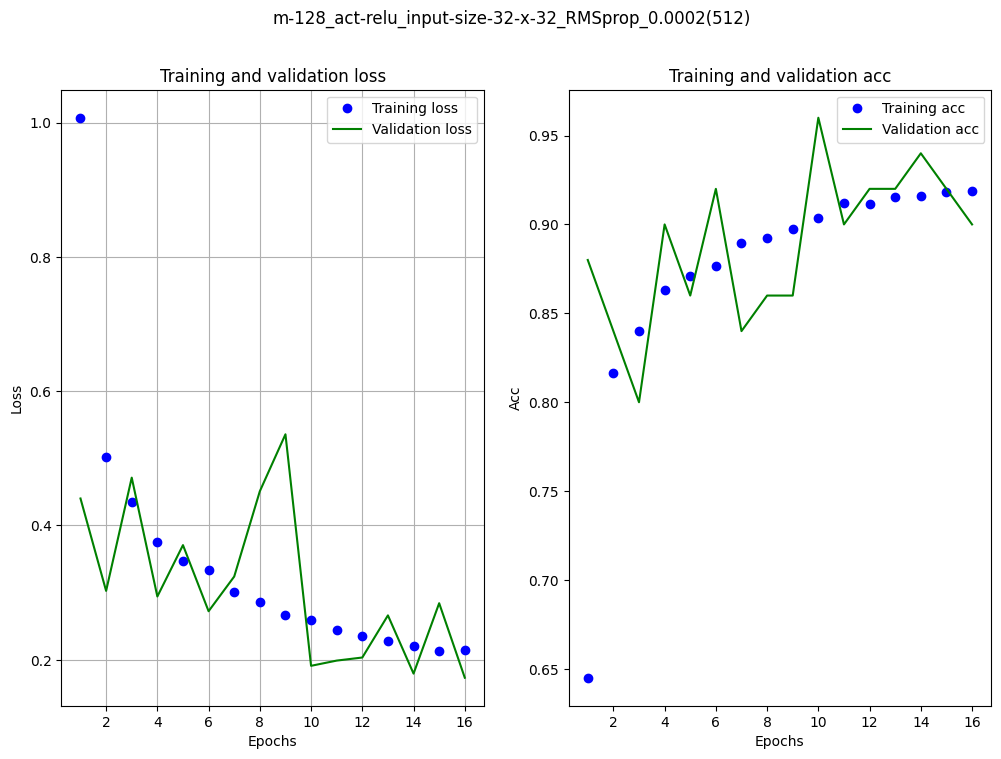

In [188]:
modelp_6 = retest_NNplus3(
                          number_pre_final_n=128,
                          act='relu',
                          opt=optimizers.legacy.RMSprop,
                          lr=2e-4,
                          bs=512,
                          epochs=20,
                          steps=50,
                          stop_retraining_layer='block4_conv3'
                          )

In [189]:
model = keras.models.load_model('best3.hdf5')
test_dataset = Dataset(X=images_test, y=labels_test, batch_size=1) 
test_loss, test_acc = model.evaluate(test_dataset)
print(test_loss, test_acc)

5000/5000 [==============================] - 76s 15ms/step - loss: 0.2917 - accuracy: 0.9048
0.29166534543037415 0.9047999978065491


На 10й епосі видно досить непоганий результат:<br>
Тренувальна - loss: 0.2599 - accuracy: 0.9034, валідаційна - val_loss: 0.1911 - `val_accuracy`: __0.9600__

Виявлено незначне покращення для тестової вибірки (`accuracy`: __0.9048__). Додамо ще 1 шар для перетренування.

Epoch 1/25
50/50 [==============================] - 102s 2s/step - loss: 1.1468 - accuracy: 0.5855 - val_loss: 0.4591 - val_accuracy: 0.8200
Epoch 2/25


/home/denys/.cache/pypoetry/virtualenvs/datas-cYPLqW4U-py3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 102s 2s/step - loss: 0.5531 - accuracy: 0.7973 - val_loss: 0.5355 - val_accuracy: 0.8600
Epoch 3/25
50/50 [==============================] - 101s 2s/step - loss: 0.4487 - accuracy: 0.8354 - val_loss: 0.3537 - val_accuracy: 0.8600
Epoch 4/25
50/50 [==============================] - 101s 2s/step - loss: 0.3969 - accuracy: 0.8532 - val_loss: 0.3266 - val_accuracy: 0.9000
Epoch 5/25
50/50 [==============================] - 101s 2s/step - loss: 0.3562 - accuracy: 0.8674 - val_loss: 0.4836 - val_accuracy: 0.8200
Epoch 6/25
50/50 [==============================] - 100s 2s/step - loss: 0.3307 - accuracy: 0.8779 - val_loss: 0.2745 - val_accuracy: 0.9200
Epoch 7/25
50/50 [==============================] - 101s 2s/step - loss: 0.3082 - accuracy: 0.8837 - val_loss: 0.3516 - val_accuracy: 0.8200
Epoch 8/25
50/50 [==============================] - 103s 2s/step - loss: 0.2854 - accuracy: 0.8952 - val_loss: 0.2439 - val_accuracy: 0.9200
Epoch 9/25
50/50 [======

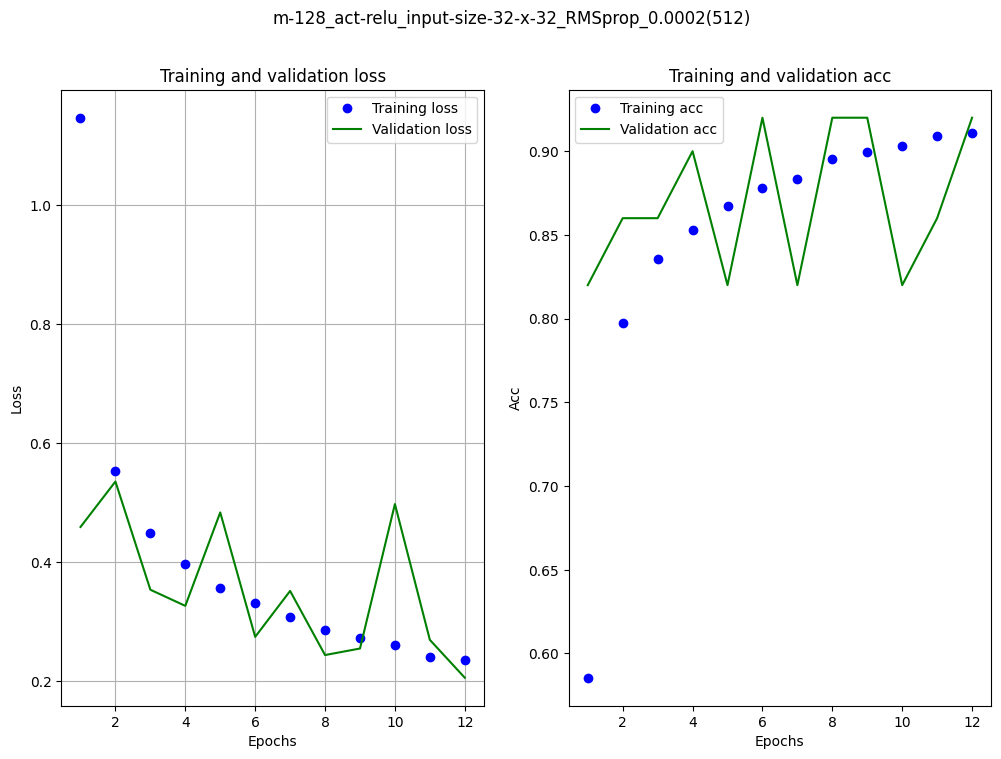

In [190]:
modelp_7 = retest_NNplus3(
                          number_pre_final_n=128,
                          act='relu',
                          opt=optimizers.legacy.RMSprop,
                          lr=2e-4,
                          bs=512,
                          epochs=25,
                          steps=50,
                          stop_retraining_layer='block4_conv2'
                          )

In [191]:
model = keras.models.load_model('best3.hdf5')
test_dataset = Dataset(X=images_test, y=labels_test, batch_size=1) 
test_loss, test_acc = model.evaluate(test_dataset)
print(test_loss, test_acc)

5000/5000 [==============================] - 77s 15ms/step - loss: 0.2983 - accuracy: 0.8998
0.29832470417022705 0.8998000025749207


Покращення не виявлено.

##### __Сonclusions 2__

Отже, існуючу натренеровану згорткову мережу можна повторно використовувати як початкові шари для нової нейронної мережі для нового набору даних, використовуючи виділення ознак, що значно облехшує та прискорює тренування та показує досить високу точність. Прийом донавчання повторно використаної частини попередньо натренованої нейронної мережі покращує результати точності, хоча і уповільнює тренування загалом, але корисне для підвищення якості моделі.